# Import Modules

In [483]:
import os
from tqdm import tqdm
import IPython.display as ipd
from IPython.display import clear_output
from collections import Counter
import soundfile as sf
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal.windows import hamming
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

!pip install librosa
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

Cek Dataset

In [218]:
# Baca metadata
train_df = pd.read_csv('Metadata_Train.csv')
test_df = pd.read_csv('Metadata_Test.csv')

print(f"Jumlah baris metadata Train: {len(train_df)}")
print(f"Jumlah baris metadata Test : {len(test_df)}")

print("\nDistribusi kelas di Train:")
print(train_df['Class'].value_counts())

train_label_dict = dict(zip(train_df['FileName'], train_df['Class']))
test_label_dict = dict(zip(test_df['FileName'], test_df['Class']))

# Cek file di folder
train_folder = 'Train_submission'
test_folder = 'Test_submission'

wav_files_in_train_folder = [f for f in os.listdir(train_folder) if f.endswith('.wav')]
wav_files_in_test_folder = [f for f in os.listdir(test_folder) if f.endswith('.wav')]

metadata_train_files = set(train_df['FileName'])
metadata_test_files = set(test_df['FileName'])
folder_train_files = set(wav_files_in_train_folder)
folder_test_files = set(wav_files_in_test_folder)

# unlabeled: ada di folder, tapi TIDAK di metadata
unlabeled_train_files = folder_train_files - metadata_train_files
unlabeled_test_files = folder_test_files - metadata_test_files

# missing: ada di metadata, tapi TIDAK di folder
missing_train_files = metadata_train_files - folder_train_files
missing_test_files = metadata_test_files - folder_test_files

print(f"\nJumlah file di Train folder yang tidak punya label: {len(unlabeled_train_files)}")
print(f"Contoh: {list(unlabeled_train_files)[:2]}")

print(f"Jumlah file di Test folder yang tidak punya label: {len(unlabeled_test_files)}")
print(f"Contoh: {list(unlabeled_test_files)[:2]}")

print(f"\nJumlah file di Train metadata tapi file tidak ada: {len(missing_train_files)}")
print(f"Contoh: {list(missing_train_files)[:2]}")

print(f"Jumlah file di Test metadata tapi file tidak ada: {len(missing_test_files)}")
print(f"Contoh: {list(missing_test_files)[:2]}")

# Buat list file valid
train_paths = []
train_labels = []
for filename in wav_files_in_train_folder:
    if filename in train_label_dict:
        train_paths.append(os.path.join(train_folder, filename))
        train_labels.append(train_label_dict[filename].lower())

test_paths = []
test_labels = []
for filename in wav_files_in_test_folder:
    if filename in test_label_dict:
        test_paths.append(os.path.join(test_folder, filename))
        test_labels.append(test_label_dict[filename].lower())

print("\nJumlah data Train (valid):", len(train_paths))
print("Jumlah data Test (valid):", len(test_paths))

print("\nDistribusi kelas di Train (valid):")
print(pd.Series(Counter(train_labels)).sort_values(ascending=False))

print("\nDistribusi kelas di Test (valid):")
print(pd.Series(Counter(test_labels)).sort_values(ascending=False))

Jumlah baris metadata Train: 2629
Jumlah baris metadata Test : 80

Distribusi kelas di Train:
Class
Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: count, dtype: int64

Jumlah file di Train folder yang tidak punya label: 700
Contoh: ['VIOLIN_sound (315).wav', '2_john-garner_bwv1002_mov7.wav']
Jumlah file di Test folder yang tidak punya label: 0
Contoh: []

Jumlah file di Train metadata tapi file tidak ada: 1
Contoh: ['029500_morning-rain-piano-65875.wav']
Jumlah file di Test metadata tapi file tidak ada: 0
Contoh: []

Jumlah data Train (valid): 1927
Jumlah data Test (valid): 80

Distribusi kelas di Train (valid):
sound_guitar    700
sound_violin    699
sound_piano     528
dtype: int64

Distribusi kelas di Test (valid):
sound_drum      20
sound_guiatr    20
sound_piano     20
sound_violin    20
dtype: int64


Cek Format & Duplikat File

In [215]:
train_df = pd.read_csv('Metadata_Train.csv')
test_df = pd.read_csv('Metadata_Test.csv')

train_folder = 'Train_submission'
test_folder = 'Test_submission'

# Cek format file di Train & Test
train_wrong_format = [f for f in os.listdir(train_folder) if not f.endswith('.wav')]
print("File di Train dengan format salah:", train_wrong_format)

test_wrong_format = [f for f in os.listdir(test_folder) if not f.endswith('.wav')]
print("File di Test dengan format salah:", test_wrong_format)

# Cek duplikat (FileName, Class) di Train
train_dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("\nJumlah baris duplikat persis di Train:", train_dup_rows.sum())

# Cek duplikat FileName saja di Train
train_fname_counts = train_df['FileName'].value_counts()
train_fname_dups = train_fname_counts[train_fname_counts > 1]
print("Jumlah FileName yang duplikat di Train:", len(train_fname_dups))
if not train_fname_dups.empty:
    print(train_fname_dups)

# Cek duplikat (FileName, Class) di Test
test_dup_rows = test_df.duplicated(subset=['FileName', 'Class'])
print("\nJumlah baris duplikat persis di Test:", test_dup_rows.sum())

# Cek duplikat FileName saja di Test
test_fname_counts = test_df['FileName'].value_counts()
test_fname_dups = test_fname_counts[test_fname_counts > 1]
print("Jumlah FileName yang duplikat di Test:", len(test_fname_dups))
if not test_fname_dups.empty:
    print(test_fname_dups)

File di Train dengan format salah: []
File di Test dengan format salah: []

Jumlah baris duplikat persis di Train: 0
Jumlah FileName yang duplikat di Train: 700
FileName
loop-16247.wav              3
DRUM_SOUND (22).wav         2
DRUM_SOUND (23).wav         2
DRUM_SOUND (24).wav         2
DRUM_SOUND (25).wav         2
                           ..
WaveDrum02_45SD (95).wav    2
WaveDrum02_45SD (96).wav    2
WaveDrum02_45SD (97).wav    2
WaveDrum02_45SD (98).wav    2
WaveDrum02_45SD (99).wav    2
Name: count, Length: 700, dtype: int64

Jumlah baris duplikat persis di Test: 0
Jumlah FileName yang duplikat di Test: 0


Cek Durasi & Sample Rate Audio

Error reading 029500_morning-rain-piano-65875.wav in Train: [Errno 2] No such file or directory: 'Train_submission\\029500_morning-rain-piano-65875.wav'

Train Dataset
Jumlah file error: 1
Sample rate unik: {24000, 16000, 32000, 48000, 44100}
Durasi min  : 1.06 detik
Durasi max  : 128.06 detik
Durasi mean : 17.9 detik


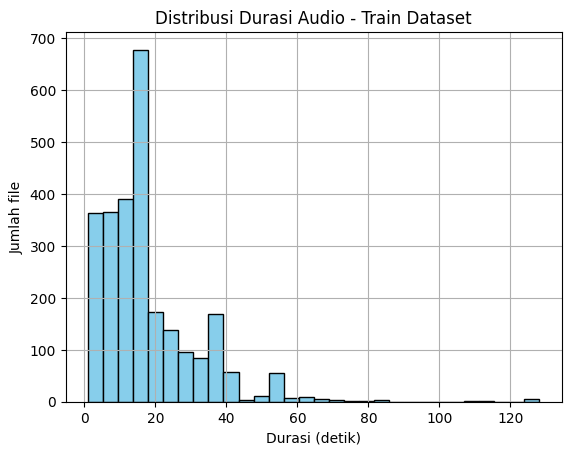


Test Dataset
Jumlah file error: 0
Sample rate unik: {24000, 16000, 44100, 48000}
Durasi min  : 3.24 detik
Durasi max  : 110.23 detik
Durasi mean : 24.07 detik


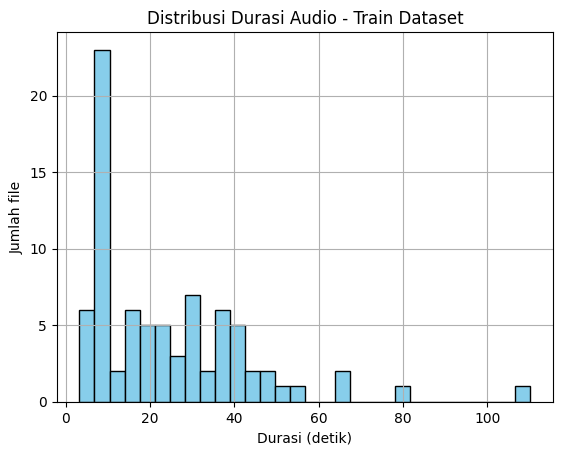

In [295]:
train_df = pd.read_csv('Metadata_Train.csv')
test_df = pd.read_csv('Metadata_Test.csv')

# Cek Train
train_durations = []
train_sr = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('Train_submission', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("\nTrain Dataset")
print("Jumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

    plt.hist(train_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio - Train Dataset")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

# Cek Test
test_durations = []
test_sr = []
test_errors = []

for fn in test_df['FileName']:
    path = os.path.join('Test_submission', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        test_durations.append(len(y) / sr)
        test_sr.append(sr)
    except Exception as e:
        print(f"Error reading {fn} in Test: {e}")
        test_errors.append(fn)

print("\nTest Dataset")
print("Jumlah file error:", len(test_errors))
print("Sample rate unik:", set(test_sr))
if test_durations:
    print("Durasi min  :", round(min(test_durations), 2), "detik")
    print("Durasi max  :", round(max(test_durations), 2), "detik")
    print("Durasi mean :", round(sum(test_durations)/len(test_durations), 2), "detik")

    plt.hist(test_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio - Train Dataset")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

Cek Outlier Durasi

In [217]:
train_df = pd.read_csv('Metadata_Train.csv')
test_df = pd.read_csv('Metadata_Test.csv')

# Cek Train
train_durations = []
train_files = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('Train_submission', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        dur = len(y) / sr
        train_durations.append(dur)
        train_files.append(fn)
    except:
        train_errors.append(fn)

# Convert ke numpy
train_dur_np = np.array(train_durations)

print("Outlier Durasi Train")
print("Jumlah file < 2 detik :", np.sum(train_dur_np < 2))
print("Jumlah file > 5 detik :", np.sum(train_dur_np > 5))

# Cek Test
test_durations = []
test_files = []
test_errors = []

for fn in test_df['FileName']:
    path = os.path.join('Test_submission', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        dur = len(y) / sr
        test_durations.append(dur)
        test_files.append(fn)
    except:
        test_errors.append(fn)

# Convert ke numpy
test_dur_np = np.array(test_durations)

print("\nOutlier Durasi Test")
print("Jumlah file < 2 detik :", np.sum(test_dur_np < 2))
print("Jumlah file > 5 detik :", np.sum(test_dur_np > 5))

Outlier Durasi Train
Jumlah file < 2 detik : 49
Jumlah file > 5 detik : 2281

Outlier Durasi Test
Jumlah file < 2 detik : 0
Jumlah file > 5 detik : 78


Visualisasi Dataset Awal

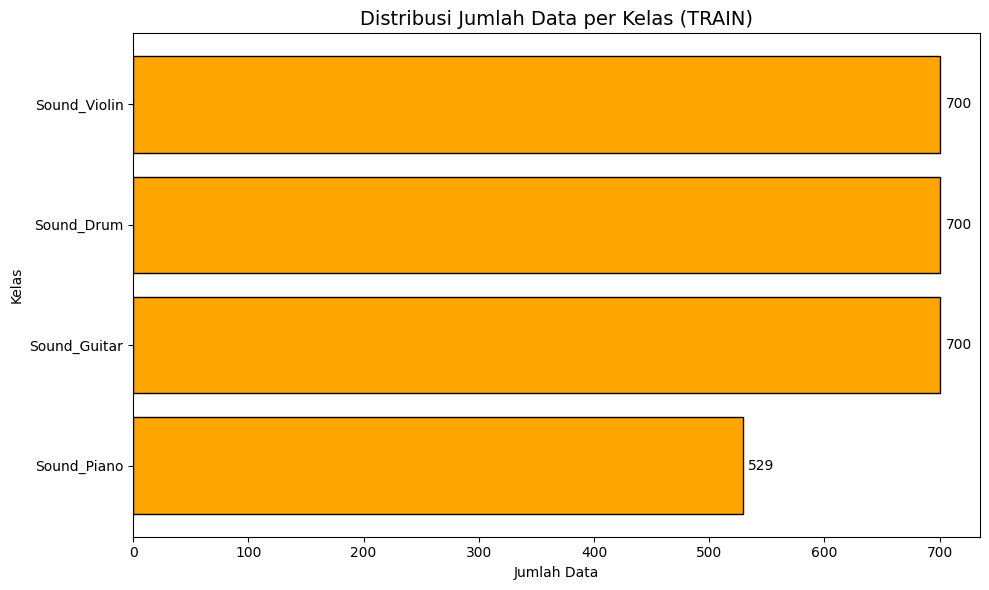

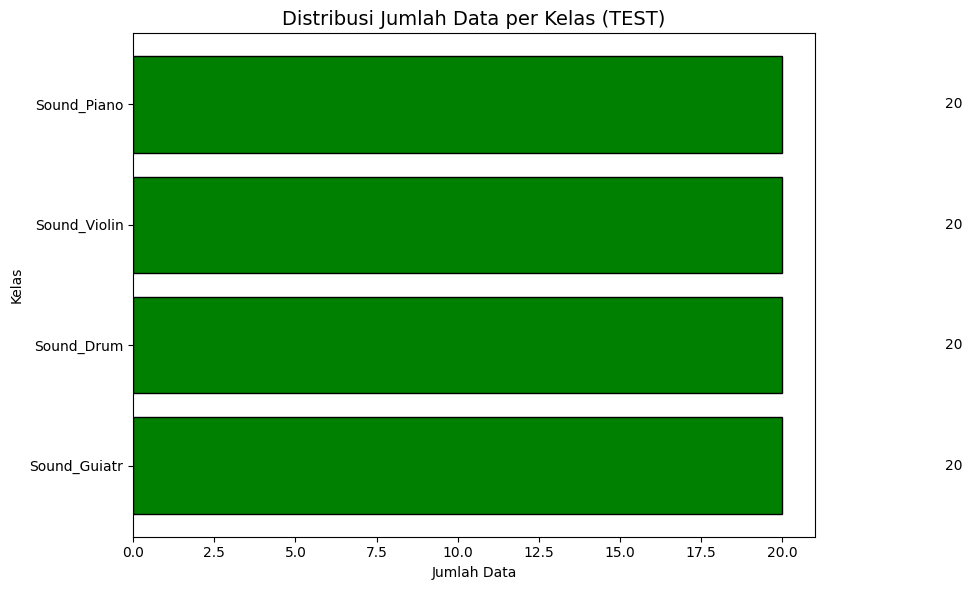

In [251]:
train_df = pd.read_csv('Metadata_Train.csv')
test_df = pd.read_csv('Metadata_Test.csv')

plt.figure(figsize=(10, 6))
bars = plt.barh(train_class_counts.index, train_class_counts.values,
                color='orange', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas (TRAIN)', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.barh(test_class_counts.index, test_class_counts.values,
                color='green', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas (TEST)', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

# Preprocessing Data Train

 Metadata & File Valid

In [229]:
train_df = pd.read_csv('Metadata_Train.csv')
        
train_folder = 'Train_submission'
clean_folder = 'Train_submission_clean'
    
train_label_dict = dict(zip(train_df['FileName'], train_df['Class']))
    
# Ambil file yang valid
clean_train_data = []
for filename in os.listdir(train_folder):
    if filename.endswith('.wav') and filename in train_label_dict:
        clean_train_data.append({
            'file_path': os.path.join(train_folder, filename),
            'filename': filename,
            'label': train_label_dict[filename].lower()
        })
    
print(f"Jumlah file Train valid: {len(clean_train_data)}")
    
# Distribusi kelas
if clean_train_data:
    train_label_counts = Counter([item['label'] for item in clean_train_data])
    print("\nDistribusi kelas Train (valid):")
    for label, count in sorted(train_label_counts.items()):
        print(f"  {label}: {count}")
    
# Simpan metadata valid
clean_train_df = pd.DataFrame({
    'FileName': [item['filename'] for item in clean_train_data],
    'Class': [item['label'] for item in clean_train_data]
})
clean_train_df.to_csv('Metadata_Train_Clean.csv', index=False)
print("\nMetadata Train valid disimpan")
    
# Buat folder baru untuk file valid
if not os.path.exists(clean_folder):
    os.makedirs(clean_folder)
    
for filename in clean_train_df['FileName']:
    src = os.path.join(train_folder, filename)
    dst = os.path.join(clean_folder, filename)
    shutil.copy2(src, dst)
    
print(f"Semua file valid disalin ke folder")

Jumlah file Train valid: 1927

Distribusi kelas Train (valid):
  sound_guitar: 700
  sound_piano: 528
  sound_violin: 699

Metadata Train valid disimpan
Semua file valid disalin ke folder


Cek Format & Duplikasi File

In [359]:
train_df = pd.read_csv('Metadata_Train_Clean.csv')
train_folder = 'Train_submission_clean'

# Cek format file di Train & Test
train_wrong_format = [f for f in os.listdir(train_folder) if not f.endswith('.wav')]
print("File di Train dengan format salah:", train_wrong_format)

# Cek duplikat (FileName, Class) di Train
train_dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("\nJumlah baris duplikat persis di Train:", train_dup_rows.sum())

# Cek duplikat FileName saja di Train
train_fname_counts = train_df['FileName'].value_counts()
train_fname_dups = train_fname_counts[train_fname_counts > 1]
print("Jumlah FileName yang duplikat di Train:", len(train_fname_dups))
if not train_fname_dups.empty:
    print(train_fname_dups)

File di Train dengan format salah: []

Jumlah baris duplikat persis di Train: 0
Jumlah FileName yang duplikat di Train: 0


Standarisasi Sample Rate

In [238]:
def standardize_sample_rate(input_folder, output_folder, target_sr=44100):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
    print(f"Jumlah file: {len(files)}")

    for f in files:
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f)

        # Baca audio dan ubah sample rate
        y, sr = librosa.load(input_path, sr=None) 
        if sr != target_sr:
            y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sf.write(output_path, y_resampled, target_sr)
        else:
            # Kalau sample rate sudah sama, tetap salin
            sf.write(output_path, y, sr)

    print("\nSemua file sudah distandarisasi ke {} Hz & disimpan di: {}".format(target_sr, output_folder))

standardize_sample_rate(
    input_folder='Train_submission_clean',
    output_folder='Train_submission_44100Hz',
    target_sr=44100
)

Jumlah file: 1927

Semua file sudah distandarisasi ke 44100 Hz & disimpan di: Train_submission_44100Hz


Filter Durasi

In [328]:
def standardize_duration(input_folder, output_folder, target_sr=44100, target_duration=3.0):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
    print(f"Jumlah file: {len(files)}")

    target_length = int(target_sr * target_duration)

    for f in files:
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f)

        try:
            y, sr = librosa.load(input_path, sr=target_sr)

            original_len = len(y)

            if original_len < target_length:
                # Pad dengan zero di tengah
                pad_length = target_length - original_len
                pad_before = pad_length // 2
                pad_after = pad_length - pad_before
                y = np.pad(y, (pad_before, pad_after), mode='constant')
                action = f"padded ({len(y)/sr:.2f}s)"

            elif original_len > target_length:
                # Ambil bagian tengah
                start = (original_len - target_length) // 2
                end = start + target_length
                y = y[start:end]
                action = f"cropped middle ({len(y)/sr:.2f}s)"

            else:
                action = "unchanged"

            # Simpan file hasil standarisasi
            sf.write(output_path, y, target_sr)

        except Exception as e:
            print(f"Error processing {f}: {e}")
            continue

    print(f"\nSemua file distandarisasi ke {target_duration} detik dan disimpan di: {output_folder}")

standardize_duration(
    input_folder='Train_submission_44100Hz',
    output_folder='Train_submission_44100Hz_3s_perbarui',
    target_sr=44100,
    target_duration=3.0
)

Jumlah file: 1927

Semua file distandarisasi ke 3.0 detik dan disimpan di: Train_submission_44100Hz_3s_perbarui


Normalisasi Audio

In [349]:
AUDIO_DIR = 'Train_submission_44100Hz_3s_perbarui'
OUTPUT_DIR = 'Train_submission_44100Hz_3s_fixed'
EXPECTED_DURATION = 3.0
SILENCE_THRESHOLD = 0.003
instrument = ''
target_db = -20.0

# Buat folder output
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Fungsi normalisasi
def normalize_audio(input_path, output_path, target_db=-20.0):
    y, sr = librosa.load(input_path, sr=None)
    rms = np.sqrt(np.mean(y**2))
    current_db = 20 * np.log10(rms + 1e-6)
    gain_db = target_db - current_db
    gain = 10 ** (gain_db / 20)
    y_boosted = y * gain
    max_val = np.max(np.abs(y_boosted))
    if max_val > 1:
        y_boosted = y_boosted / max_val
    sf.write(output_path, y_boosted, sr)
    print(f"✅ Dinormalisasi: {os.path.basename(output_path)}")

df = pd.read_csv('Metadata_Train_Clean.csv')

# Filter berdasarkan instrumen
filtered = df[df['Class'].str.lower().str.startswith(instrument.lower())]

# Simpan file
to_normalize = []

# Loop semua file
for idx, row in filtered.iterrows():
    file_name = row['FileName']
    full_path = os.path.join(AUDIO_DIR, file_name)
    output_path = os.path.join(OUTPUT_DIR, file_name)

    try:
        y, sr = librosa.load(full_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)

        # Deteksi anomali
        is_anomaly = False
        if duration < EXPECTED_DURATION:
            print(f"- {file_name}: Durasi kurang")

        rms = np.sqrt(np.mean(y ** 2))
        if rms < SILENCE_THRESHOLD:
            print(f"- {file_name}: Terlalu sunyi / tidak ada suara")
            is_anomaly = True

        spec = np.abs(librosa.stft(y))
        spectral_flatness = librosa.feature.spectral_flatness(S=spec)
        if np.mean(spectral_flatness) > 1.0:
            print(f"- {file_name}: Spektrum terlalu flat (mungkin noise)")

        # Simpan hasil
        if is_anomaly:
            normalize_audio(full_path, output_path, target_db)
        else:
            shutil.copy2(full_path, output_path)
            print(f"📁 Disalin tanpa perubahan: {file_name}")

    except Exception as e:
        print(f"Error memproses {file_name}: {str(e)}")

print("\n✅ Semua file telah diproses dan disalin ke folder output.")

- 035568_upright-piano-71570.wav: Terlalu sunyi / tidak ada suara
✅ Dinormalisasi: 035568_upright-piano-71570.wav
📁 Disalin tanpa perubahan: 04-47367.wav
📁 Disalin tanpa perubahan: 046578_tribal-drum-rhythms-03wav-68096.wav
📁 Disalin tanpa perubahan: 054399_8039s-old-school-rap-drum-loop-80433.wav
📁 Disalin tanpa perubahan: 056514_drum-40118.wav
📁 Disalin tanpa perubahan: 059960_sonido2-sincopa-alta-7mp3-47316.wav
📁 Disalin tanpa perubahan: 060311_rubbing-drum-sticksaif-82905.wav
📁 Disalin tanpa perubahan: 065339_metal-bass-drum-90850.wav
📁 Disalin tanpa perubahan: 066166_qui-c39est-qu39est-tombe-loop-t85wav-39366.wav
- 068320_hang-drum-2wav-80568.wav: Terlalu sunyi / tidak ada suara
✅ Dinormalisasi: 068320_hang-drum-2wav-80568.wav
📁 Disalin tanpa perubahan: 1-E1-Major 00.wav
📁 Disalin tanpa perubahan: 1-E1-Major 01.wav
📁 Disalin tanpa perubahan: 1-E1-Major 02.wav
📁 Disalin tanpa perubahan: 1-E1-Major 03.wav
📁 Disalin tanpa perubahan: 1-E1-Major 04.wav
📁 Disalin tanpa perubahan: 1-E1-M

Cek Sample Rate, Durasi, & Outlier File

In [476]:
train_df = pd.read_csv('Metadata_Train_Clean.csv')

# Cek Train
train_durations = []
train_sr = []
train_files = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('Train_submission_44100Hz_3s_fixed', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
        train_files.append(fn)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("Train Dataset")
print("Jumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

# Convert ke numpy
train_dur_np = np.array(train_durations)

print("\nOutlier Durasi Train")
print("Jumlah file < 2 detik :", np.sum(train_dur_np < 2))
print("Jumlah file > 5 detik :", np.sum(train_dur_np > 5))

Train Dataset
Jumlah file error: 0
Sample rate unik: {44100}
Durasi min  : 3.0 detik
Durasi max  : 3.0 detik
Durasi mean : 3.0 detik

Outlier Durasi Train
Jumlah file < 2 detik : 0
Jumlah file > 5 detik : 0


# Augmentasi Data Train

In [361]:
def augment_to_target_count(
    input_folder,
    metadata_csv,
    output_folder,
    target_sr=44100,
    target_duration=3.0,
    target_count=700,
    pitch_steps=[-2, -1, 1, 2],
    metadata_output_csv='Metadata_Train_Augmented2.csv'
):

# Augmentasi piano & violin hingga jumlahnya sama dengan target_count, hanya menggunakan pitch shift.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Baca metadata
    df = pd.read_csv(metadata_csv)
    label_dict = dict(zip(df['FileName'], df['Class']))

    new_metadata = []

    # Hitung jumlah per kelas
    class_counts = df['Class'].value_counts().to_dict()
    print("Jumlah per kelas saat ini:")
    for cls, cnt in class_counts.items():
        print(f"  {cls}: {cnt}")

    # Pilih kelas yang mau diseimbangkan
    classes_to_balance = ['sound_guitar', 'sound_piano', 'sound_violin']

    for cls in classes_to_balance:
        files = [f for f in os.listdir(input_folder)
                 if f.endswith('.wav') and label_dict.get(f).lower() == cls]

        current_count = len(files)
        needed = target_count - current_count

        print(f"\nKelas {cls}: {current_count} file, butuh augmentasi {needed} file untuk capai {target_count}")

        if needed <= 0:
            print(f"  ✓ Kelas {cls} sudah cukup")
            needed = 0

        # Salin file asli dulu & catat ke metadata baru
        for f in files:
            src = os.path.join(input_folder, f)
            dst = os.path.join(output_folder, f)
            y, sr = librosa.load(src, sr=target_sr)

            # Pastikan durasi sesuai
            target_len = int(sr * target_duration)
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)))
            else:
                y = y[:target_len]

            sf.write(dst, y, sr)
            new_metadata.append({'FileName': f, 'Class': cls})

        # Augmentasi acak dari file asli
        augmented = 0
        while augmented < needed:
            f = random.choice(files)
            y, sr = librosa.load(os.path.join(input_folder, f), sr=target_sr)

            steps = random.choice(pitch_steps)
            y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
            suffix = f"_ps{steps:+}"

            # Pad/crop ke durasi target
            target_len = int(sr * target_duration)
            if len(y_aug) < target_len:
                y_aug = np.pad(y_aug, (0, target_len - len(y_aug)))
            else:
                y_aug = y_aug[:target_len]

            # Nama file baru
            new_name = f.replace('.wav', f'_aug{augmented}{suffix}.wav')
            sf.write(os.path.join(output_folder, new_name), y_aug, sr)

            new_metadata.append({'FileName': new_name, 'Class': cls})
            augmented += 1
            print(f"  ✓ {new_name} dibuat (pitch shift {steps:+} semitone)")

    print(f"\nAugmentasi selesai file disimpan di: {output_folder}")

    # Simpan metadata baru
    new_metadata_df = pd.DataFrame(new_metadata)
    new_metadata_df.to_csv(metadata_output_csv, index=False)
    print(f"Metadata final disimpan: {metadata_output_csv}")

augment_to_target_count(
    input_folder='Train_submission_44100Hz_3s_fixed',
    metadata_csv='Metadata_Train_Clean.csv',
    output_folder='Train_submission_final2',
    target_sr=44100,
    target_duration=3.0,
    target_count=700,
    pitch_steps=[-2, -1, 1, 2],
    metadata_output_csv='Metadata_Train_Augmented2.csv'
)

Jumlah per kelas saat ini:
  sound_guitar: 700
  sound_violin: 699
  sound_piano: 528

Kelas sound_guitar: 700 file, butuh augmentasi 0 file untuk capai 700
  ✓ Kelas sound_guitar sudah cukup

Kelas sound_piano: 528 file, butuh augmentasi 172 file untuk capai 700
  ✓ ROOM_room6_MUS_swing_DEV_redmi_aug0_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ on-rd-piano-loop-2-106459_aug1_ps+2.wav dibuat (pitch shift +2 semitone)
  ✓ ROOM_room1_MUS_joplin_DEV_ipad_aug2_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ ROOM_room8_MUS_beethoven1_DEV_iphone_aug3_ps-2.wav dibuat (pitch shift -2 semitone)
  ✓ ROOM_room8_MUS_swing_DEV_lg_aug4_ps+2.wav dibuat (pitch shift +2 semitone)
  ✓ old-record-player-effect-14887_aug5_ps-2.wav dibuat (pitch shift -2 semitone)
  ✓ ROOM_room6_MUS_bartok_DEV_ipad_aug6_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ ROOM_room7_MUS_bartok_DEV_redmi_aug7_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ ROOM_room1_MUS_pachelbel_DEV_stereomic_aug8_ps-1.wav dibuat (pitch shift -1 s

Cek Distribusi Data Final

Jumlah baris metadata Train: 2100

Distribusi kelas di Train:
Class
sound_guitar    700
sound_piano     700
sound_violin    700
Name: count, dtype: int64

File di Train dengan format salah: []
Jumlah baris duplikat persis di Train: 0
Jumlah FileName yang duplikat di Train: 0

Jumlah file error: 0
Sample rate unik: {44100}
Durasi min  : 3.0 detik
Durasi max  : 3.0 detik
Durasi mean : 3.0 detik


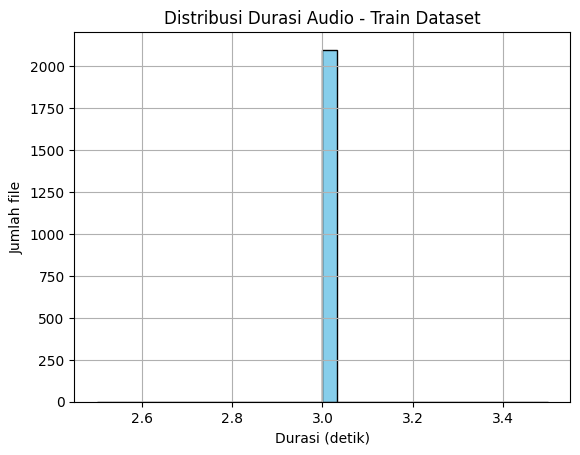


Outlier durasi Train
Jumlah file < 2 detik : 0
Jumlah file > 5 detik : 0


In [364]:
train_df = pd.read_csv('Metadata_Train_Augmented2.csv')
train_folder = 'Train_submission_final2'

print(f"Jumlah baris metadata Train: {len(train_df)}")

print("\nDistribusi kelas di Train:")
print(train_df['Class'].value_counts())

# Cek format file di Train & Test
train_wrong_format = [f for f in os.listdir(train_folder) if not f.endswith('.wav')]
print("\nFile di Train dengan format salah:", train_wrong_format)

# Cek duplikat (FileName, Class) di Train
train_dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("Jumlah baris duplikat persis di Train:", train_dup_rows.sum())

# Cek duplikat FileName saja di Train
train_fname_counts = train_df['FileName'].value_counts()
train_fname_dups = train_fname_counts[train_fname_counts > 1]
print("Jumlah FileName yang duplikat di Train:", len(train_fname_dups))
if not train_fname_dups.empty:
    print(train_fname_dups)

# Cek durasi & outlier di Train
train_durations = []
train_sr = []
train_files = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('Train_submission_final2', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
        train_files.append(fn)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("\nJumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

    plt.hist(train_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio - Train Dataset")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

# Convert ke numpy
train_dur_np = np.array(train_durations)

print("\nOutlier durasi Train")
print("Jumlah file < 2 detik :", np.sum(train_dur_np < 2))
print("Jumlah file > 5 detik :", np.sum(train_dur_np > 5))

# Visualisasi Data Train

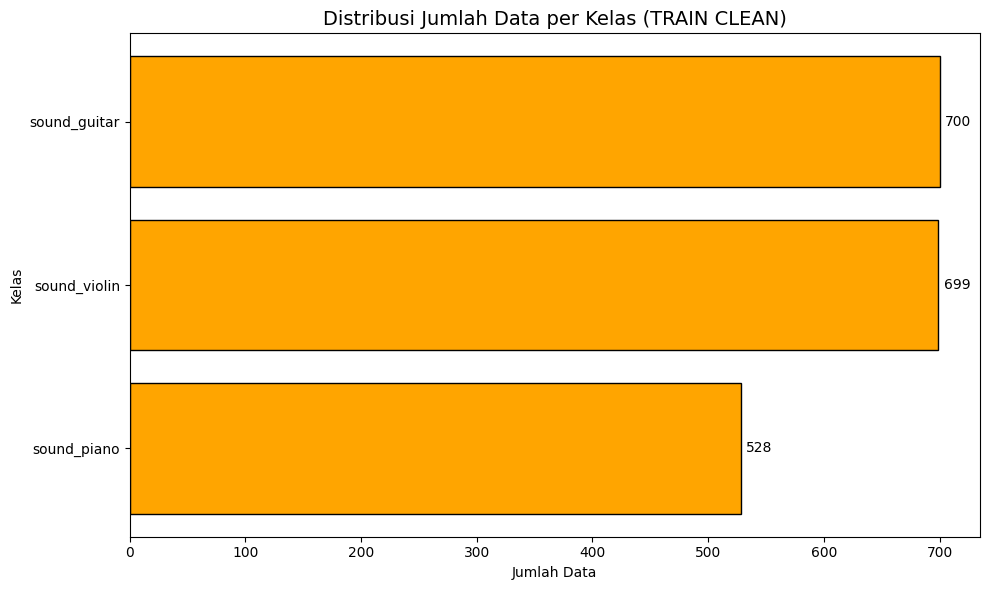

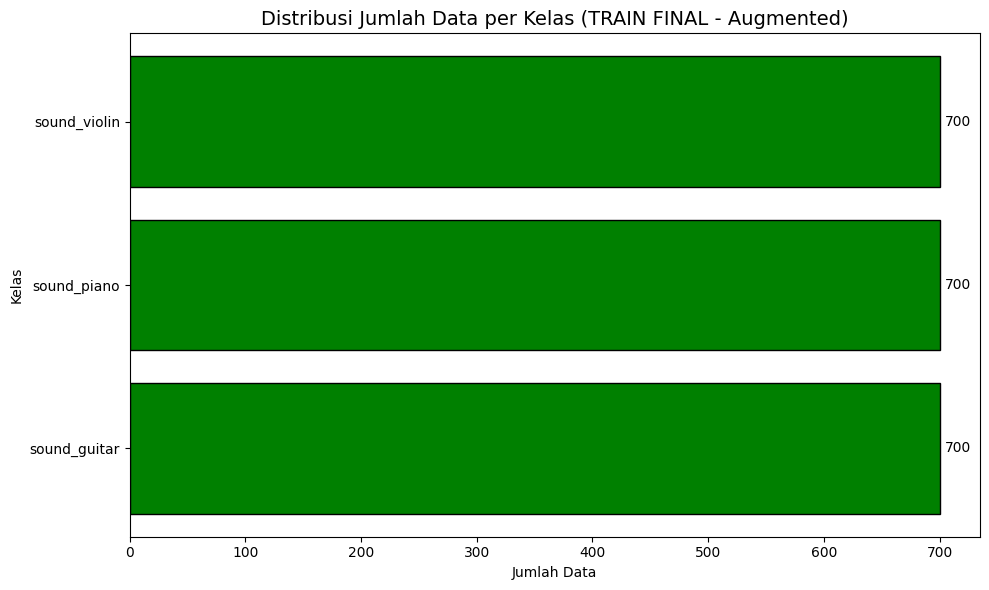

In [477]:
train_df = pd.read_csv('Metadata_Train_Clean.csv')
train_final_df = pd.read_csv('Metadata_Train_Augmented2.csv') 

train_class_counts = train_df['Class'].value_counts().sort_values()
train_final_class_counts = train_final_df['Class'].value_counts().sort_values()

# Plot metadata CLEAN (sebelum augmentasi)
plt.figure(figsize=(10, 6))
bars = plt.barh(train_class_counts.index, train_class_counts.values,
                color='orange', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas (TRAIN CLEAN)', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

# Plot metadata FINAL (sesudah augmentasi)
plt.figure(figsize=(10, 6))
bars = plt.barh(train_final_class_counts.index, train_final_class_counts.values,
                color='green', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas (TRAIN FINAL - Augmented)', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

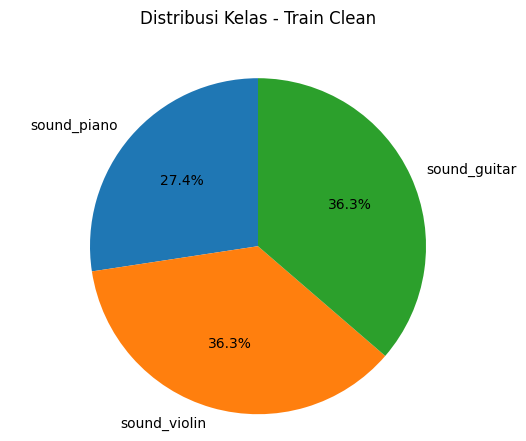

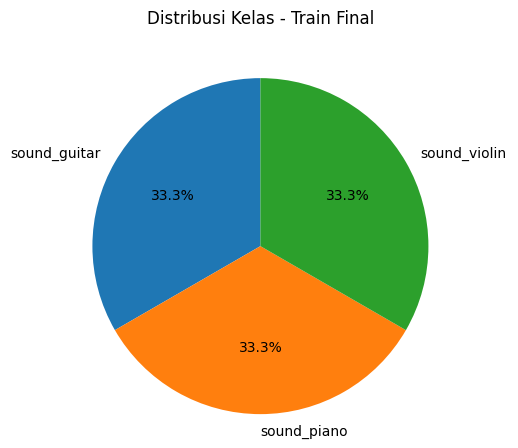

In [478]:
train_df = pd.read_csv('Metadata_Train_Clean.csv')
train_final_df = pd.read_csv('Metadata_Train_Augmented2.csv') 

train_class_counts = train_df['Class'].value_counts().sort_values()
train_final_class_counts = train_final_df['Class'].value_counts().sort_values()

# Plot metadata CLEAN (sebelum augmentasi)
fig, ax = plt.subplots()
ax.set_title('Distribusi Kelas - Train Clean', y=1.08)
ax.pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

train_df.reset_index(inplace=True)

# Plot metadata FINAL (setelah augmentasi)
fig, ax = plt.subplots()
ax.set_title('Distribusi Kelas - Train Final', y=1.08)
ax.pie(train_final_class_counts, labels=train_final_class_counts.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

train_df.reset_index(inplace=True)

Cek File Anomali

In [479]:
AUDIO_DIR = 'Train_submission_final2'
EXPECTED_DURATION = 3.0  
SILENCE_THRESHOLD = 0.003
instrument = ''  

# Load metadata
df = pd.read_csv('Metadata_Train_Clean.csv') 

# Filter hanya instrumen yang ingin diperiksa
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Untuk mencatat anomali
anomali_files = []

# Loop per file
for idx, row in filtered.iterrows():
    file_name = row['FileName']
    full_path = os.path.join(AUDIO_DIR, file_name)

    try:
        # Load file audio
        y, sr = librosa.load(full_path, sr=None)

        # Cek durasi
        duration = librosa.get_duration(y=y, sr=sr)
        if duration < EXPECTED_DURATION:
            anomali_files.append((file_name, "Durasi kurang"))

        # Cek apakah audio terlalu sunyi
        rms = np.sqrt(np.mean(y ** 2))
        if rms < SILENCE_THRESHOLD:
            anomali_files.append((file_name, "Terlalu sunyi / tidak ada suara"))

        # Cek apakah spektrum flat (noise atau file kosong)
        spec = np.abs(librosa.stft(y))
        spectral_flatness = librosa.feature.spectral_flatness(S=spec)
        if np.mean(spectral_flatness) > 1.0:  # flatness tinggi = noise / tidak ada pitch
            anomali_files.append((file_name, "Spektrum terlalu flat (mungkin noise)"))

    except Exception as e:
        anomali_files.append((file_name, f"Error saat dibaca: {str(e)}"))

# Tampilkan hasil
if anomali_files:
    print("Ditemukan file dengan potensi anomali:")
    for file, issue in anomali_files:
        print(f"- {file}: {issue}")
else:
    print("Semua file audio terlihat normal.")

Semua file audio terlihat normal.


Cek Distribusi

Train Dataset
Jumlah file error: 0
Sample rate unik: {44100}
Durasi min  : 3.0 detik
Durasi max  : 3.0 detik
Durasi mean : 3.0 detik


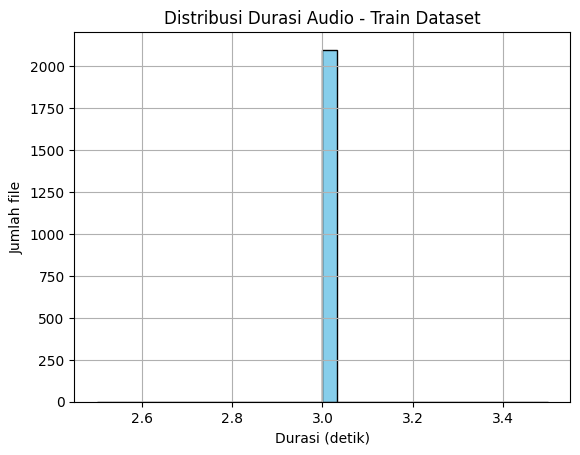

In [480]:
train_df = pd.read_csv('Metadata_Train_Augmented2.csv')

# Cek Train
train_durations = []
train_sr = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('Train_submission_final2', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("Train Dataset")
print("Jumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

    plt.hist(train_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio - Train Dataset")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

Visualisasi waveform

In [298]:
def plot_waveform(data, sr, label):
    plt.figure(figsize=(10, 4))
    plt.title(f'Waveform: {label}', fontsize=16)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Fungsi untuk menampilkan spectrogram
def plot_spectrogram(data, sr, label):
    X = librosa.stft(data)
    X_db = librosa.amplitude_to_db(np.abs(X))

    plt.figure(figsize=(10, 4))
    plt.title(f'Spectrogram: {label}', fontsize=16)
    librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

File ditemukan: Train_submission_final\04-47367.wav


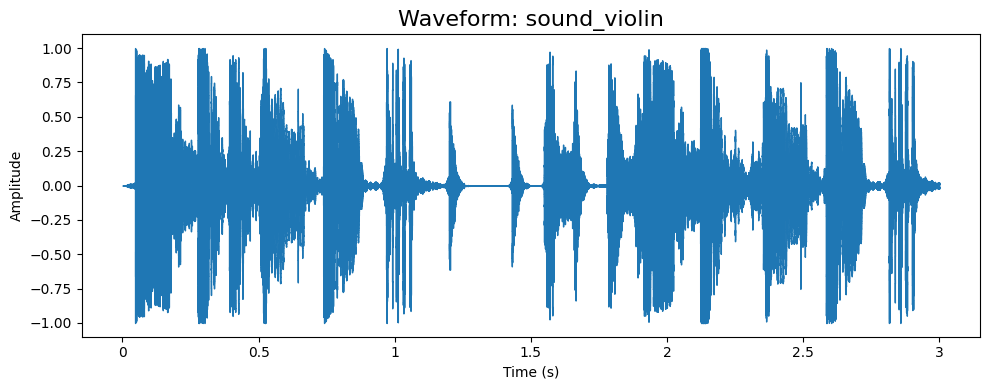

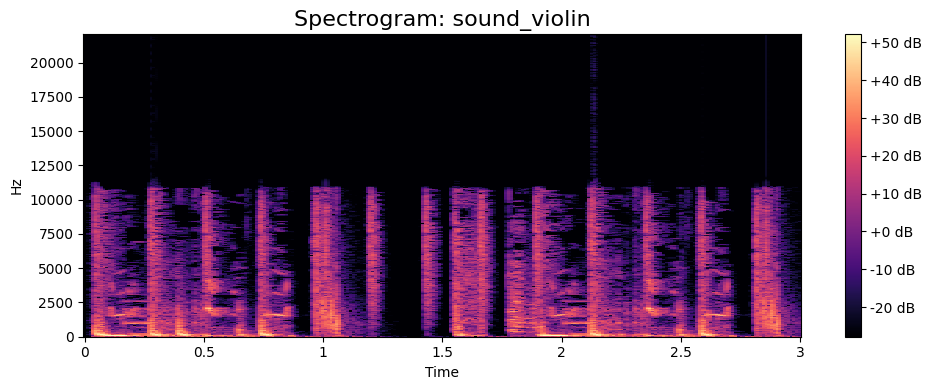

In [299]:
instrument = 'sound_violin'

# Cari baris yang cocok
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Cek apakah ditemukan
if not filtered.empty:
    file_path = filtered['FileName'].iloc[0]
    full_path = os.path.join('Train_submission_final', file_path)
    print("File ditemukan:", full_path)
    
    # LOAD audio di sini
    audio_data, sr = librosa.load(full_path, sr=None)

    # Plot
    plot_waveform(audio_data, sr, instrument)
    plot_spectrogram(audio_data, sr, instrument)
    
    display(Audio(audio_data, rate=sr))
else:
    print(f"Tidak ada file untuk instrumen: {instrument}")

File ditemukan: Train_submission_final\035568_upright-piano-71570.wav


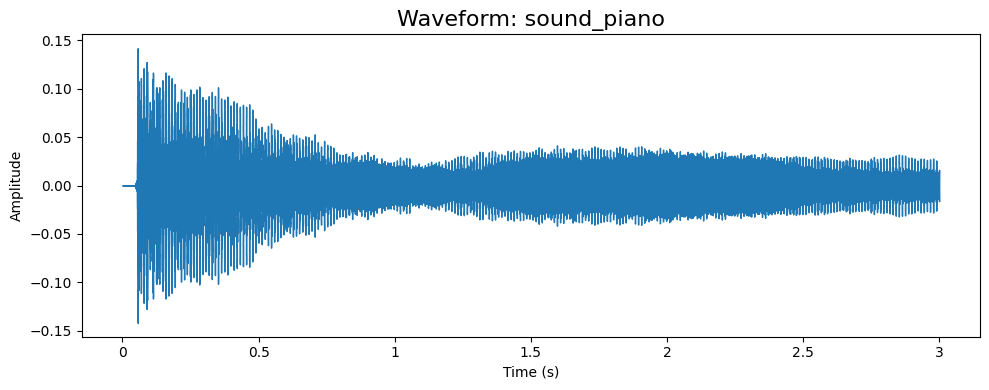

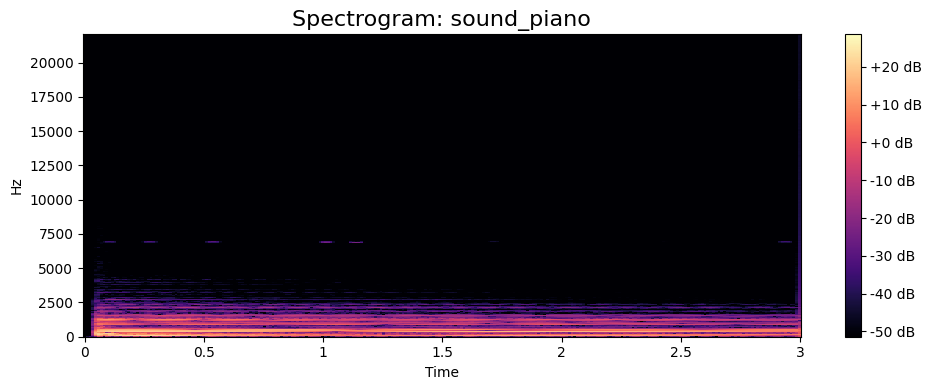

In [300]:
instrument = 'sound_piano'
target_file = '035568_upright-piano-71570.wav'

# Cari baris yang cocok
filtered = df[(df['Class'].str.lower() == instrument.lower()) & (df['FileName'] == target_file)]

# Cek apakah ditemukan
if not filtered.empty:
    file_path = filtered['FileName'].iloc[0]
    full_path = os.path.join('Train_submission_final', file_path)
    print("File ditemukan:", full_path)
    
    # LOAD audio di sini
    audio_data, sr = librosa.load(full_path, sr=None)

    # Plot
    plot_waveform(audio_data, sr, instrument)
    plot_spectrogram(audio_data, sr, instrument)
    
    display(Audio(audio_data, rate=sr))
else:
    print(f"Tidak ada file untuk instrumen: {instrument}")

File ditemukan: Train_submission\1-E1-Major 00.wav


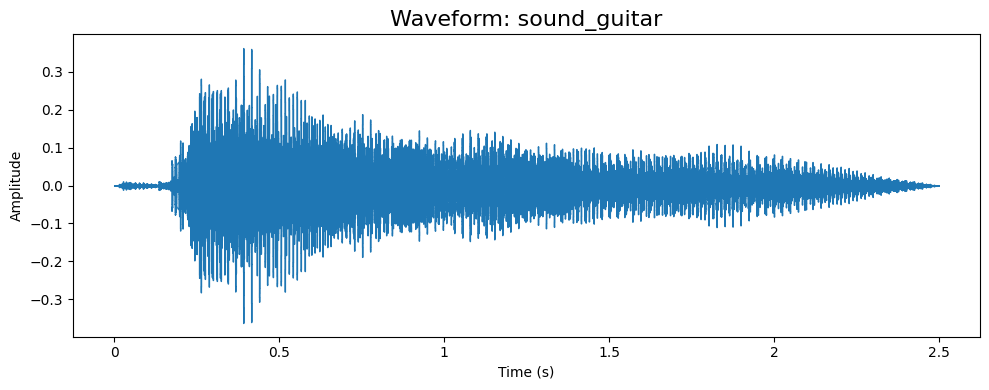

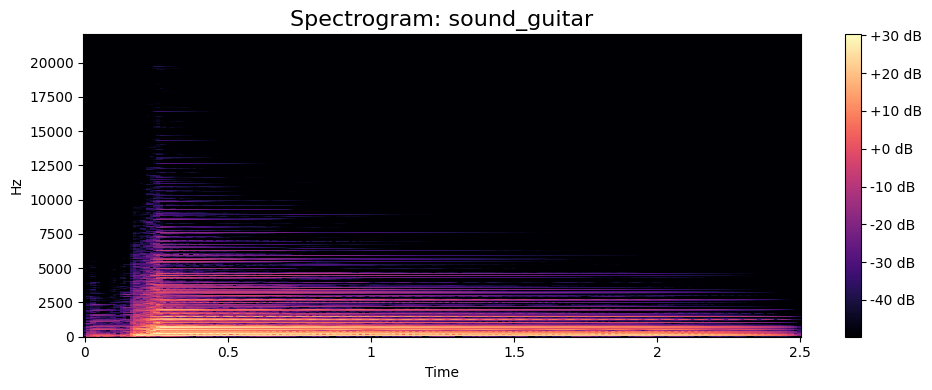

In [301]:
instrument = 'sound_guitar'

# Cari baris yang cocok
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Cek apakah ditemukan
if not filtered.empty:
    file_path = filtered['FileName'].iloc[0]
    full_path = os.path.join('Train_submission', file_path)
    print("File ditemukan:", full_path)
    
    # LOAD audio di sini
    audio_data, sr = librosa.load(full_path, sr=None)

    # Plot
    plot_waveform(audio_data, sr, instrument)
    plot_spectrogram(audio_data, sr, instrument)
    
    display(Audio(audio_data, rate=sr))
else:
    print(f"Tidak ada file untuk instrumen: {instrument}")

# Preprocessing Data Test

In [306]:
test_df = pd.read_csv('Metadata_Test.csv')
test_folder = 'Test_submission'
clean_folder = 'Test_submission_clean'

# Label target yang ingin disimpan
target_labels = ['sound_guiatr', 'sound_piano', 'sound_violin']

test_label_dict = dict(zip(test_df['FileName'], test_df['Class']))

# Ambil file yang valid dan sesuai label target
clean_test_data = []
for filename in os.listdir(test_folder):
    if filename.endswith('.wav') and filename in test_label_dict:
        label = test_label_dict[filename].lower()
        if label in target_labels:
            clean_test_data.append({
                'file_path': os.path.join(test_folder, filename),
                'filename': filename,
                'label': label
            })

print(f"Jumlah file Test valid (3 kelas): {len(clean_test_data)}")

# Distribusi kelas
if clean_test_data:
    test_label_counts = Counter([item['label'] for item in clean_test_data])
    print("\nDistribusi kelas Test (valid):")
    for label, count in sorted(test_label_counts.items()):
        print(f"  {label}: {count}")

# Simpan metadata valid
clean_test_df = pd.DataFrame({
    'FileName': [item['filename'] for item in clean_test_data],
    'Class': [item['label'] for item in clean_test_data]
})
clean_test_df.to_csv('Metadata_Test_Final.csv', index=False)
print("\nMetadata Test valid disimpan ke Metadata_Test_Final.csv")

# Buat folder untuk file valid jika belum ada
if not os.path.exists(clean_folder):
    os.makedirs(clean_folder)

# Salin file audio yang valid ke folder tujuan
for filename in clean_test_df['FileName']:
    src = os.path.join(test_folder, filename)
    dst = os.path.join(clean_folder, filename)
    shutil.copy2(src, dst)

print(f"Semua file valid disalin ke folder '{clean_folder}'")

Jumlah file Test valid (3 kelas): 60

Distribusi kelas Test (valid):
  sound_guiatr: 20
  sound_piano: 20
  sound_violin: 20

Metadata Test valid disimpan ke Metadata_Test_Final.csv
Semua file valid disalin ke folder 'Test_submission_clean'


In [307]:
def standardize_sample_rate(input_folder, output_folder, target_sr=44100):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
    print(f"Jumlah file: {len(files)}")

    for f in files:
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f)

        # Baca audio dan ubah sample rate
        y, sr = librosa.load(input_path, sr=None) 
        if sr != target_sr:
            y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sf.write(output_path, y_resampled, target_sr)
        else:
            # Kalau sample rate sudah sama, tetap salin
            sf.write(output_path, y, sr)

    print("\nSemua file sudah distandarisasi ke {} Hz & disimpan di: {}".format(target_sr, output_folder))

standardize_sample_rate(
    input_folder='Test_submission_clean',
    output_folder='Test_submission_44100Hz',
    target_sr=44100
)

Jumlah file: 60

Semua file sudah distandarisasi ke 44100 Hz & disimpan di: Test_submission_44100Hz


In [597]:
def standardize_duration(input_folder, output_folder, target_sr=44100, target_duration=3.0):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
    print(f"Jumlah file: {len(files)}")

    target_length = int(target_sr * target_duration)

    for f in files:
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f)

        try:
            y, sr = librosa.load(input_path, sr=target_sr)

            original_len = len(y)

            if original_len < target_length:
                # Pad dengan zero di tengah
                pad_length = target_length - original_len
                pad_before = pad_length // 2
                pad_after = pad_length - pad_before
                y = np.pad(y, (pad_before, pad_after), mode='constant')
                action = f"padded ({len(y)/sr:.2f}s)"

            elif original_len > target_length:
                # Ambil bagian tengah
                start = (original_len - target_length) // 2
                end = start + target_length
                y = y[start:end]
                action = f"cropped middle ({len(y)/sr:.2f}s)"

            else:
                action = "unchanged"

            # Simpan file hasil standarisasi
            sf.write(output_path, y, target_sr)

        except Exception as e:
            print(f"Error processing {f}: {e}")
            continue

    print(f"\nSemua file distandarisasi ke {target_duration} detik dan disimpan di: {output_folder}")

standardize_duration(
    input_folder='Test_submission_44100Hz',
    output_folder='Test_submission_final',
    target_sr=44100,
    target_duration=3.0
)

Jumlah file: 60

Semua file distandarisasi ke 3.0 detik dan disimpan di: Test_submission_final


Jumlah baris metadata Test: 60

Distribusi kelas di Test:
Class
sound_guiatr    20
sound_piano     20
sound_violin    20
Name: count, dtype: int64

File di Test dengan format salah: []
Jumlah baris duplikat persis di Test: 0
Jumlah FileName yang duplikat di Test: 0

Jumlah file error: 0
Sample rate unik: {44100}
Durasi min  : 3.0 detik
Durasi max  : 3.0 detik
Durasi mean : 3.0 detik


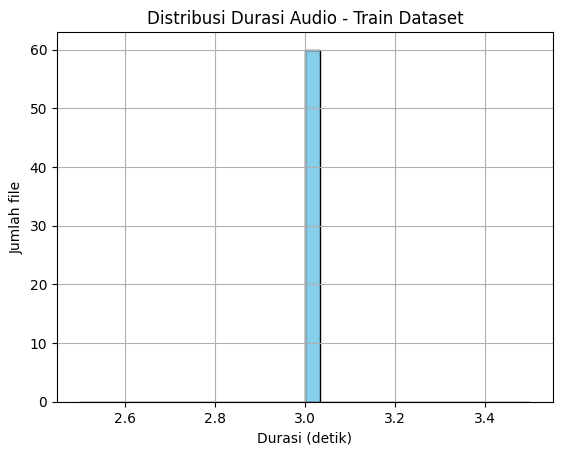

In [598]:
test_df = pd.read_csv('Metadata_Test_Final.csv')
test_folder = 'Test_submission_final'

print(f"Jumlah baris metadata Test: {len(test_df)}")

print("\nDistribusi kelas di Test:")
print(test_df['Class'].value_counts())

# Cek format file di Test
test_wrong_format = [f for f in os.listdir(test_folder) if not f.endswith('.wav')]
print("\nFile di Test dengan format salah:", test_wrong_format)

# Cek duplikat (FileName, Class) di Test
test_dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("Jumlah baris duplikat persis di Test:", test_dup_rows.sum())

# Cek duplikat FileName saja di Test
test_fname_counts = test_df['FileName'].value_counts()
test_fname_dups = test_fname_counts[test_fname_counts > 1]
print("Jumlah FileName yang duplikat di Test:", len(test_fname_dups))
if not test_fname_dups.empty:
    print(test_fname_dups)

# Cek durasi & outlier di Test
test_durations = []
test_sr = []
test_files = []
test_errors = []

for fn in test_df['FileName']:
    path = os.path.join('Test_submission_final', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        test_durations.append(len(y) / sr)
        test_sr.append(sr)
        test_files.append(fn)
    except Exception as e:
        print(f"Error reading {fn} in Test: {e}")
        test_errors.append(fn)

print("\nJumlah file error:", len(test_errors))
print("Sample rate unik:", set(test_sr))
if test_durations:
    print("Durasi min  :", round(min(test_durations), 2), "detik")
    print("Durasi max  :", round(max(test_durations), 2), "detik")
    print("Durasi mean :", round(sum(test_durations)/len(test_durations), 2), "detik")

    plt.hist(test_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio - Train Dataset")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

# Framing & Windowing

In [371]:
def framing_windowing(signal, sample_rate=44100, frame_duration=0.025, hop_duration=0.01):
    frame_length = int(frame_duration * sample_rate)
    hop_length = int(hop_duration * sample_rate)

    # Jika sinyal terlalu pendek
    if len(signal) < frame_length:
        return np.array([])

    num_frames = 1 + int((len(signal) - frame_length) / hop_length)
    frames = np.zeros((num_frames, frame_length))
    window = hamming(frame_length, sym=False)
    
    for i in range(num_frames):
        start = i * hop_length
        frames[i] = signal[start:start + frame_length] * window
        
    return frames

INPUT_DIR = 'Train_submission_final2'
FRAME_DURATION = 0.025  # 25ms
HOP_DURATION = 0.01     # 10ms
OUTPUT_DIR = 'Framed_Features_NPZ'

os.makedirs(OUTPUT_DIR, exist_ok=True)

all_framed_data = {}

for file_name in os.listdir(INPUT_DIR):
    if file_name.endswith('.wav'):
        file_path = os.path.join(INPUT_DIR, file_name)
        try:
            y, sr = librosa.load(file_path, sr=44100)
            frames = framing_windowing(y, sample_rate=sr, frame_duration=FRAME_DURATION, hop_duration=HOP_DURATION)

            if frames.size > 0:
                all_framed_data[file_name] = frames
                npz_name = os.path.splitext(file_name)[0] + '.npz'
                np.savez_compressed(os.path.join(OUTPUT_DIR, npz_name),
                                    frames=frames, sr=sr)
                
                print(f"{file_name} → {frames.shape[0]} frame disimpan")
            else:
                print(f"{file_name} → sinyal terlalu pendek")

        except Exception as e:
            print(f"Gagal memproses {file_name}: {e}")

print("\nSemua hasil framing telah disimpan di folder:", OUTPUT_DIR)

035568_upright-piano-71570.wav → 298 frame disimpan
04-47367.wav → 298 frame disimpan
046578_tribal-drum-rhythms-03wav-68096.wav → 298 frame disimpan
054399_8039s-old-school-rap-drum-loop-80433.wav → 298 frame disimpan
056514_drum-40118.wav → 298 frame disimpan
059960_sonido2-sincopa-alta-7mp3-47316.wav → 298 frame disimpan
060311_rubbing-drum-sticksaif-82905.wav → 298 frame disimpan
065339_metal-bass-drum-90850.wav → 298 frame disimpan
066166_qui-c39est-qu39est-tombe-loop-t85wav-39366.wav → 298 frame disimpan
068320_hang-drum-2wav-80568.wav → 298 frame disimpan
1-E1-Major 00.wav → 298 frame disimpan
1-E1-Major 01.wav → 298 frame disimpan
1-E1-Major 02.wav → 298 frame disimpan
1-E1-Major 03.wav → 298 frame disimpan
1-E1-Major 04.wav → 298 frame disimpan
1-E1-Major 05.wav → 298 frame disimpan
1-E1-Major 06.wav → 298 frame disimpan
1-E1-Major 07.wav → 298 frame disimpan
1-E1-Major 08.wav → 298 frame disimpan
1-E1-Major 09.wav → 298 frame disimpan
1-E1-Major 10.wav → 298 frame disimpan
10

Cek Hasil Framing

In [383]:
file_path = 'Framed_Features_NPZ/140-bpm-amen-break-original-processed-6945.npz'

data = np.load(file_path)

# Daftar key
print("Keys di dalam .npz:", data.files)

frames = data['frames']     
sr = data['sr']          

# Cek bentuk data
print("Shape frames:", frames.shape)
print("Sample rate:", sr)

# Lihat isi frame
df_frames = pd.DataFrame(frames)
print(df_frames.head())  

Keys di dalam .npz: ['frames', 'sr']
Shape frames: (298, 1102)
Sample rate: 44100
       0         1         2         3         4         5         6     \
0  0.002947  0.009015  0.011230  0.007001  0.001963  0.001016  0.002533   
1  0.015967  0.016357  0.012216  0.007445  0.004572  0.003313  0.003839   
2  0.009688 -0.000100 -0.005732  0.000506  0.010969  0.013408  0.006854   
3  0.014932  0.009662  0.006985  0.007577  0.007778  0.006933  0.008199   
4 -0.011707 -0.009686 -0.021937 -0.034375 -0.036236 -0.032556 -0.031811   

       7         8         9     ...      1092      1093      1094      1095  \
0  0.003250  0.003839  0.006332  ...  0.011291  0.014026  0.010868  0.006239   
1  0.007811  0.014446  0.018961  ...  0.010111  0.007948  0.009357  0.013183   
2 -0.000177 -0.002299 -0.000664  ... -0.074944 -0.075068 -0.073582 -0.072476   
3  0.012479  0.016438  0.016986  ... -0.051327 -0.050103 -0.053583 -0.054509   
4 -0.033159 -0.032962 -0.033169  ...  0.012092  0.003008  0.000084 

# Ekstraksi Fitur

In [566]:
def apply_hamming_window(frame):
    hamming_window = hamming(len(frame))
    return frame * hamming_window
    
def load_npz_file(npz_path):
    data = np.load(npz_path)
    frames = data['frames']
    sr = int(data['sr'])
    return frames, {'sr': sr}

Zero Crossing Rate (ZCR)

In [567]:
def calculate_zcr(frame):
    # Menghitung tanda dari setiap sampel
    signs = np.sign(frame)
    # Menghitung perubahan tanda
    sign_changes = np.diff(signs)
    # Menghitung jumlah zero crossing
    if len(frame) > 1:
        zcr = np.sum(np.abs(sign_changes)) / (2 * (len(frame) - 1))
    else:
        zcr = 0
    return zcr

RMS Energy

In [568]:
def calculate_rms(frame):
    if len(frame) > 0:
        rms = np.sqrt(np.mean(frame**2))
    else:
        rms = 0
    return rms

Spectral Centroid

In [580]:
def calculate_spectral_centroid(frame, sr=44100):
    # Konversi ke domain frekuensi menggunakan FFT
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    
    # Membuat array frekuensi
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    # Menghitung spectral centroid
    if np.sum(magnitude) > 0:
        spectral_centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
    else:
        spectral_centroid = 0
        
    return spectral_centroid

Spectral Spread 

In [581]:
def calculate_spectral_spread(frame, sr=44100):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    power_spectrum = magnitude ** 2
    
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    centroid = np.sum(freqs * power_spectrum) / (np.sum(power_spectrum) + 1e-10)
    
    spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * power_spectrum) / (np.sum(power_spectrum) + 1e-10))
    
    return spread

Spectral Roll-off

In [582]:
def calculate_spectral_rolloff(frame, sr=44100, roll_percent=0.85):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    power_spectrum = magnitude ** 2
    
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    cumulative_power = np.cumsum(power_spectrum)
    total_power = cumulative_power[-1]
    threshold = roll_percent * total_power
    
    idx = np.where(cumulative_power >= threshold)[0]
    if len(idx) > 0:
        rolloff_freq = freqs[idx[0]]
    else:
        rolloff_freq = freqs[-1]
    return rolloff_freq

In [583]:
def extract_features_per_frame(frame, sr=44100):
    frame = apply_hamming_window(frame)
    
    # Ekstraksi fitur
    zcr = calculate_zcr(frame)
    rms = calculate_rms(frame)
    spectral_centroid = calculate_spectral_centroid(frame, sr)
    spread = calculate_spectral_spread(frame, sr)
    rolloff = calculate_spectral_rolloff(frame, sr)
    
    return {
        'zcr': zcr,
        'rms': rms,
        'spectral_centroid': spectral_centroid,
        'spectral_spread': spread,
        'spectral_rolloff': rolloff,
    }

In [584]:
def process_npz_dataset(metadata_path, npz_dir, output_csv=None, sr=44100):
    metadata = pd.read_csv(metadata_path)
    results = []
    
    # Loop setiap baris di metadata
    for idx, row in metadata.iterrows():
        filename = row['FileName'] 
        
        base_name = os.path.splitext(filename)[0]
        npz_filename = base_name + '.npz'
        npz_path = os.path.join(npz_dir, npz_filename)
        
        try:
            # Load file NPZ
            frames, npz_metadata = load_npz_file(npz_path)
            
            if frames is None:
                print(f"Could not load frames from {npz_filename}")
                continue
            
            features_list = []
            
            # Ekstrak fitur untuk setiap frame
            for frame_idx, frame in enumerate(frames):
                # Pastikan frame adalah 1D array
                if frame.ndim > 1:
                    frame = frame.flatten()
                
                features = extract_features_per_frame(frame, sr)
                features_list.append(features)
            
            # Hitung statistik dari semua frame
            if features_list:
                df_features = pd.DataFrame(features_list)
                stats = {
                    'FileName': filename,
                    'num_frames': len(frames),

                    # ZCR
                    'zcr_mean': df_features['zcr'].mean(),
                    'zcr_std': df_features['zcr'].std(),

                    # RMS
                    'rms_mean': df_features['rms'].mean(),
                    'rms_std': df_features['rms'].std(),

                    # Spectral Centroid
                    'spectral_centroid_mean': df_features['spectral_centroid'].mean(),
                    'spectral_centroid_std': df_features['spectral_centroid'].std(),

                    # Spectral Spread
                    'spectral_spread_mean': df_features['spectral_spread'].mean(),
                    'spectral_spread_std': df_features['spectral_spread'].std(),

                    # Spectral Roll-Off
                    'spectral_rolloff_mean': df_features['spectral_rolloff'].mean(),
                    'spectral_rolloff_std': df_features['spectral_rolloff'].std(),
                }
                
                # Gabungkan dengan metadata asli
                for col in row.index:
                    if col != 'FileName':  # Hindari duplikat filename
                        stats[col] = row[col]
                
                results.append(stats)
            
        except Exception as e:
            print(f"Error processing {npz_filename}: {str(e)}")
            continue
    
    # Buat DataFrame hasil
    if results:
        result_df = pd.DataFrame(results)
        
        if output_csv:
            result_df.to_csv(output_csv, index=False)
            print(f"Semua hasil telah disimpan di folder: {output_csv}")
        
        return result_df
    else:
        print("No files were successfully processed!")
        return pd.DataFrame()

process_npz_dataset(
    metadata_path='Metadata_Train_Augmented2.csv',
    npz_dir='Framed_Features_NPZ',
    output_csv='fitur_ekstraksi.csv',
    sr=44100
)

Semua hasil telah disimpan di folder: fitur_ekstraksi.csv


,FileName,num_frames,zcr_mean,zcr_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_spread_mean,spectral_spread_std,spectral_rolloff_mean,spectral_rolloff_std,Class
0,1-E1-Major 00.wav,298,0.014203,0.007548,0.019303,0.015585,570.330613,355.599129,214.447835,116.288269,381.918172,204.527533,sound_guitar
1,1-E1-Major 01.wav,298,0.013773,0.009596,0.028927,0.027728,699.596194,886.941439,263.987420,389.916037,379.903836,303.176972,sound_guitar
2,1-E1-Major 02.wav,298,0.017103,0.011700,0.029819,0.028273,821.281617,982.397911,336.813098,392.094614,412.133217,228.774860,sound_guitar
3,1-E1-Major 03.wav,298,0.014464,0.007901,0.024090,0.021107,604.414459,453.842183,212.477476,164.902482,355.866089,198.271059,sound_guitar
4,1-E1-Major 04.wav,298,0.015931,0.008978,0.026609,0.024564,653.238676,418.554132,246.200379,147.357843,400.584355,221.500587,sound_guitar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,WaveDrum02_45SD (96).wav,298,0.088140,0.027024,0.003599,0.008135,4343.294941,1059.159688,2057.448659,792.596533,1972.169576,1626.536934,sound_violin
2096,WaveDrum02_45SD (97).wav,298,0.031251,0.023881,0.002531,0.013085,3086.535721,1793.266291,1148.689861,786.434756,647.944859,668.350555,sound_violin
2097,WaveDrum02_45SD (98).wav,298,0.270596,0.263380,0.002942,0.008467,8541.518235,5218.893855,4395.084348,3096.979137,8494.993544,9833.095382,sound_violin
2098,WaveDrum02_45SD (99).wav,298,0.072649,0.023190,0.005912,0.011319,3556.033783,444.199085,1563.513789,403.901982,1723.869048,1271.926447,sound_violin


In [586]:
from scipy.fftpack import dct

metadata_train = pd.read_csv("Metadata_Train_Augmented2.csv")  
npz_folder = "Framed_Features_NPZ"

mfcc_list = []

for _, row in metadata_train.iterrows():
    filename = row['FileName'].replace('.wav', '.npz')
    label = row['Class']
    file_path = os.path.join(npz_folder, filename)

    try:
        # Set Parameter
        data = np.load(file_path)
        frames = data['frames']
        sr = int(data['sr'])
        n_fft = 2048
        n_mfcc = 13  

        if frames.shape[0] == 0:
            print(f"{filename} kosong → dilewati")
            continue
            
        if frames.shape[1] != n_fft:
            pad_width = max(0, n_fft - frames.shape[1])
            frames = np.pad(frames[:, :n_fft], ((0, 0), (0, pad_width)), mode='constant')

        # FFT Setiap Frame
        fft_frames = np.fft.rfft(frames, axis=1)
        power_spectrum = np.abs(fft_frames) ** 2
        log_power_spectrum = np.log10(power_spectrum + 1e-10)

        # Filterbank Mel
        mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mfcc)
        mel_spec = np.dot(power_spectrum, mel_filter.T)
        log_mel_spec = np.log(mel_spec + 1e-10)

        # DCT → MFCC
        mfcc = dct(log_mel_spec, type=2, axis=1, norm='ortho')[:, :n_mfcc]
        mfcc_mean = np.mean(mfcc, axis=0)
        mfcc_std = np.std(mfcc, axis=0)

        # Simpan list
        row_data = [filename] + mfcc_mean.tolist() + mfcc_std.tolist() + [label]
        mfcc_list.append(row_data)
    
    except Exception as e:
        print(f"Gagal memproses {filename}: {e}")

# Simpan ke file CSV
mfcc_columns = ['FileName'] + [f'MFCC_Mean_{i+1}' for i in range(n_mfcc)] + [f'MFCC_Std_{i+1}' for i in range(n_mfcc)] + ['Class']

df_train_mfcc = pd.DataFrame(mfcc_list, columns=mfcc_columns)
df_train_mfcc.to_csv("fitur_ekstraksi_mfcc.csv", index=False)

print(f"\nProses selesai MFCC disimpan di: {df_train_mfcc}")


Proses selesai MFCC disimpan di:                            FileName  MFCC_Mean_1  MFCC_Mean_2  MFCC_Mean_3  \
0                 1-E1-Major 00.npz   -39.284717    15.644383     0.418043   
1                 1-E1-Major 01.npz   -38.023906    15.346034     0.333696   
2                 1-E1-Major 02.npz   -36.690272    15.310236    -0.656118   
3                 1-E1-Major 03.npz   -38.259291    15.221868     0.051649   
4                 1-E1-Major 04.npz   -37.239832    15.376122    -0.273933   
...                             ...          ...          ...          ...   
2095       WaveDrum02_45SD (96).npz   -35.222543     7.909631    -0.804103   
2096       WaveDrum02_45SD (97).npz   -57.312276     7.348482     0.565615   
2097       WaveDrum02_45SD (98).npz   -49.378316     7.394123     1.836694   
2098       WaveDrum02_45SD (99).npz   -29.102290     8.423479    -1.381906   
2099  DRUM_SOUND (20)_aug0_ps-2.npz   -38.257556     5.739453     0.247686   

      MFCC_Mean_4  MFCC_Mean_

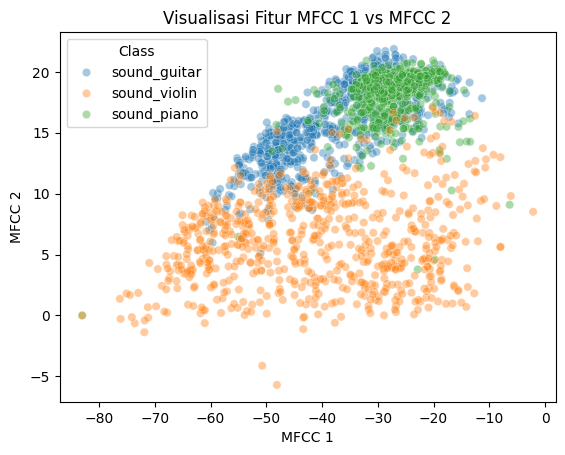

In [587]:
df = pd.read_csv("fitur_ekstraksi_mfcc.csv")

# Ambil 2 fitur MFCC untuk scatterplot
X = df[['MFCC_Mean_1', 'MFCC_Mean_2']]
y = df['Class']

# Visualisasi
sns.scatterplot(x=X['MFCC_Mean_1'],
                y=X['MFCC_Mean_2'],
                hue=y,
                hue_order=["sound_guitar", "sound_violin", "sound_piano"],
                alpha=0.4)

plt.title("Visualisasi Fitur MFCC 1 vs MFCC 2")
plt.xlabel("MFCC 1")
plt.ylabel("MFCC 2")
plt.show()

In [588]:
df_fitur = pd.read_csv("fitur_ekstraksi.csv")
df_mfcc  = pd.read_csv("fitur_ekstraksi_mfcc.csv")

# Hapus ekstensi di kedua dataframe
df_fitur['FileName'] = df_fitur['FileName'].str.replace('.wav', '', regex=False)
df_mfcc['FileName']  = df_mfcc['FileName'].str.replace('.npz', '', regex=False)
df_gabung = pd.merge(df_fitur, df_mfcc, on=['FileName', 'Class'])

# Cek hasil kolom gabungan
print(df_gabung.columns.tolist())

# Urutkan kolom
cols = (['FileName'] + 
        [col for col in df_gabung.columns if col not in ['FileName', 'Class']] + 
        ['Class'])
df_gabung = df_gabung[cols]

# Simpan hasil gabungan
df_gabung.to_csv("fitur_ekstraksi_gabungan.csv", index=False)
print("Berhasil digabung")

['FileName', 'num_frames', 'zcr_mean', 'zcr_std', 'rms_mean', 'rms_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_spread_mean', 'spectral_spread_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'Class', 'MFCC_Mean_1', 'MFCC_Mean_2', 'MFCC_Mean_3', 'MFCC_Mean_4', 'MFCC_Mean_5', 'MFCC_Mean_6', 'MFCC_Mean_7', 'MFCC_Mean_8', 'MFCC_Mean_9', 'MFCC_Mean_10', 'MFCC_Mean_11', 'MFCC_Mean_12', 'MFCC_Mean_13', 'MFCC_Std_1', 'MFCC_Std_2', 'MFCC_Std_3', 'MFCC_Std_4', 'MFCC_Std_5', 'MFCC_Std_6', 'MFCC_Std_7', 'MFCC_Std_8', 'MFCC_Std_9', 'MFCC_Std_10', 'MFCC_Std_11', 'MFCC_Std_12', 'MFCC_Std_13']
Berhasil digabung


In [589]:
df_gabung = pd.read_csv("fitur_ekstraksi.csv")
df_gabung.head()

,FileName,num_frames,zcr_mean,zcr_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_spread_mean,spectral_spread_std,spectral_rolloff_mean,spectral_rolloff_std,Class
0,1-E1-Major 00.wav,298,0.014203,0.007548,0.019303,0.015585,570.330613,355.599129,214.447835,116.288269,381.918172,204.527533,sound_guitar
1,1-E1-Major 01.wav,298,0.013773,0.009596,0.028927,0.027728,699.596194,886.941439,263.987420,389.916037,379.903836,303.176972,sound_guitar
2,1-E1-Major 02.wav,298,0.017103,0.011700,0.029819,0.028273,821.281617,982.397911,336.813098,392.094614,412.133217,228.774860,sound_guitar
3,1-E1-Major 03.wav,298,0.014464,0.007901,0.024090,0.021107,604.414459,453.842183,212.477476,164.902482,355.866089,198.271059,sound_guitar
4,1-E1-Major 04.wav,298,0.015931,0.008978,0.026609,0.024564,653.238676,418.554132,246.200379,147.357843,400.584355,221.500587,sound_guitar


In [590]:
df_gabung = pd.read_csv("fitur_ekstraksi_gabungan.csv")
df_gabung.head()

,FileName,num_frames,zcr_mean,zcr_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_spread_mean,spectral_spread_std,...,MFCC_Std_5,MFCC_Std_6,MFCC_Std_7,MFCC_Std_8,MFCC_Std_9,MFCC_Std_10,MFCC_Std_11,MFCC_Std_12,MFCC_Std_13,Class
0,1-E1-Major 00,298,0.014203,0.007548,0.019303,0.015585,570.330613,355.599129,214.447835,116.288269,...,0.566540,0.517515,0.390596,0.344214,0.232847,0.230371,0.218120,0.234856,0.343526,sound_guitar
1,1-E1-Major 01,298,0.013773,0.009596,0.028927,0.027728,699.596194,886.941439,263.987420,389.916037,...,0.620139,0.476152,0.293712,0.269450,0.230451,0.187279,0.178858,0.213004,0.304632,sound_guitar
2,1-E1-Major 02,298,0.017103,0.011700,0.029819,0.028273,821.281617,982.397911,336.813098,392.094614,...,0.681959,0.666244,0.355195,0.354541,0.226984,0.290826,0.197805,0.172041,0.224349,sound_guitar
3,1-E1-Major 03,298,0.014464,0.007901,0.024090,0.021107,604.414459,453.842183,212.477476,164.902482,...,0.866116,0.634586,0.364015,0.337140,0.326697,0.268414,0.265372,0.183033,0.283908,sound_guitar
4,1-E1-Major 04,298,0.015931,0.008978,0.026609,0.024564,653.238676,418.554132,246.200379,147.357843,...,0.791649,0.643256,0.334182,0.437014,0.286762,0.239963,0.268468,0.220766,0.239517,sound_guitar


# Model SVM

In [610]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib

# Load data train
df_train = pd.read_csv("fitur_ekstraksi_gabungan.csv")

# Eksperimen fitur
important_mfcc = [col for col in df_train.columns if 'MFCC_Mean_' in col and int(col.split('_')[-1]) <= 13]

experiments = {
    'ZCR': ['zcr_mean', 'zcr_std'],
    'RMS': ['rms_mean', 'rms_std'],
    'Spectral': [
        'spectral_centroid_mean', 'spectral_centroid_std', 
        'spectral_spread_mean', 'spectral_spread_std', 
        'spectral_rolloff_mean', 'spectral_rolloff_std'
    ],
    'MFCC_13': important_mfcc,
    'BestCombo': ['zcr_mean', 'rms_mean', 'spectral_centroid_mean'] + important_mfcc,
    'AllFeatures': [col for col in df_train.columns if col not in ['FileName', 'Class']]
}

# Label
y_train = df_train['Class']

# Parameter grid
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale"],
    "kernel": ["rbf"]
}

# Stratified K-Fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop eksperimen
for exp_name, feature_cols in experiments.items():
    print(f"\nEksperimen: {exp_name}")

    # Ambil subset fitur sesuai eksperimen
    X_train_exp = df_train[feature_cols]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_exp)

    # Grid Search + SVM
    svm = SVC(class_weight='balanced', probability=True, random_state=42)
    grid = GridSearchCV(svm, param_grid=param_grid, cv=cv_strategy, scoring='accuracy', verbose=0, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    
    print("Best Params:", grid.best_params_)
    print("Best CV Accuracy:", grid.best_score_)

    # Simpan model dan scaler per eksperimen
    joblib.dump(grid, f"model_{exp_name}.joblib")
    joblib.dump(scaler, f"scaler_{exp_name}.joblib")

print("\nSemua model eksperimen berhasil disimpan.")


Eksperimen: ZCR
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.7857142857142857

Eksperimen: RMS
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.7300000000000001

Eksperimen: Spectral
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.8214285714285715

Eksperimen: MFCC_13
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9328571428571429

Eksperimen: BestCombo
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9385714285714286

Eksperimen: AllFeatures
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9647619047619047

Semua model eksperimen berhasil disimpan.


# Evaluasi Model

Evaluasi di Data Test

In [611]:
for exp_name in experiments.keys():
    print(exp_name, os.path.getsize(f"model_{exp_name}.joblib"))

ZCR 60939
RMS 70875
Spectral 78731
MFCC_13 81451
BestCombo 91387
AllFeatures 170315



Evaluasi Eksperimen: ZCR
Akurasi  : 0.6000
Precision: 0.6605
Recall   : 0.6000
F1-Score : 0.6050

Classification Report:
              precision    recall  f1-score   support

sound_guitar       0.85      0.55      0.67        20
 sound_piano       0.47      0.75      0.58        20
sound_violin       0.67      0.50      0.57        20

    accuracy                           0.60        60
   macro avg       0.66      0.60      0.61        60
weighted avg       0.66      0.60      0.61        60



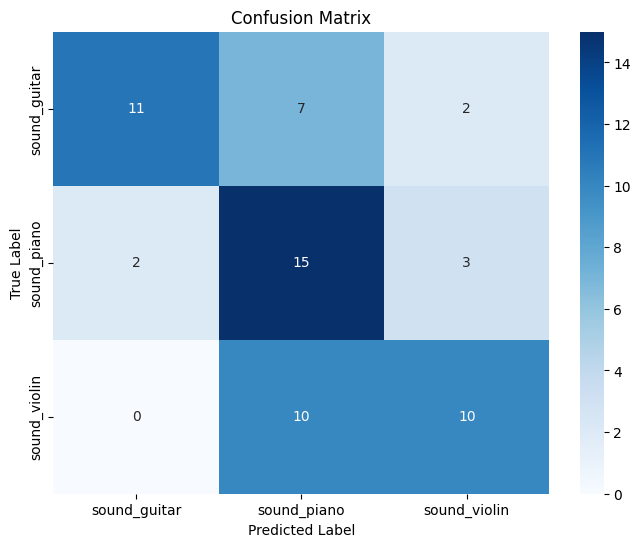


Evaluasi Eksperimen: RMS
Akurasi  : 0.3500
Precision: 0.3958
Recall   : 0.3500
F1-Score : 0.3201

Classification Report:
              precision    recall  f1-score   support

sound_guitar       0.38      0.45      0.41        20
 sound_piano       0.31      0.50      0.38        20
sound_violin       0.50      0.10      0.17        20

    accuracy                           0.35        60
   macro avg       0.40      0.35      0.32        60
weighted avg       0.40      0.35      0.32        60



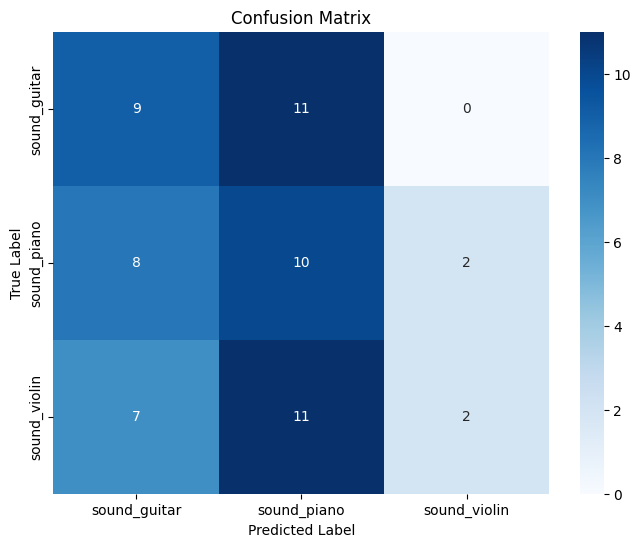


Evaluasi Eksperimen: Spectral
Akurasi  : 0.4500
Precision: 0.5088
Recall   : 0.4500
F1-Score : 0.4166

Classification Report:
              precision    recall  f1-score   support

sound_guitar       0.77      0.50      0.61        20
 sound_piano       0.36      0.75      0.48        20
sound_violin       0.40      0.10      0.16        20

    accuracy                           0.45        60
   macro avg       0.51      0.45      0.42        60
weighted avg       0.51      0.45      0.42        60



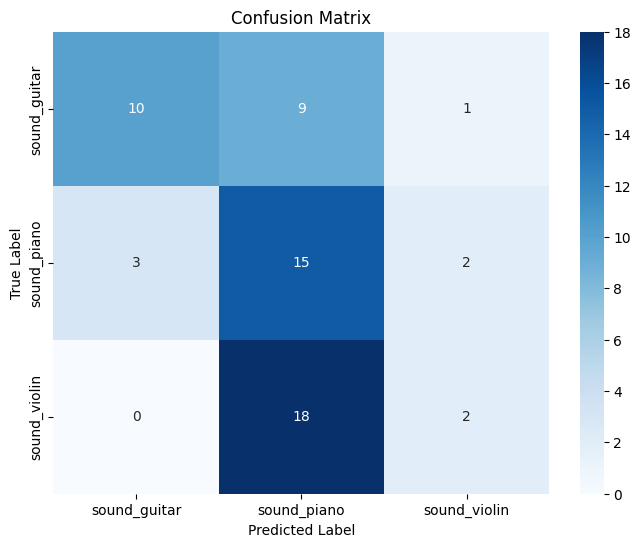


Evaluasi Eksperimen: MFCC_13
Akurasi  : 0.4500
Precision: 0.5380
Recall   : 0.4500
F1-Score : 0.4069

Classification Report:
              precision    recall  f1-score   support

sound_guitar       0.58      0.55      0.56        20
 sound_piano       0.37      0.70      0.48        20
sound_violin       0.67      0.10      0.17        20

    accuracy                           0.45        60
   macro avg       0.54      0.45      0.41        60
weighted avg       0.54      0.45      0.41        60



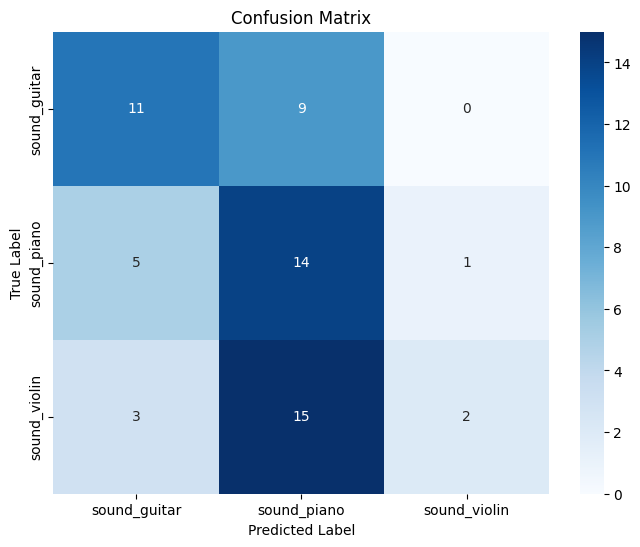


Evaluasi Eksperimen: BestCombo
Akurasi  : 0.5667
Precision: 0.6165
Recall   : 0.5667
F1-Score : 0.5736

Classification Report:
              precision    recall  f1-score   support

sound_guitar       0.65      0.55      0.59        20
 sound_piano       0.43      0.65      0.52        20
sound_violin       0.77      0.50      0.61        20

    accuracy                           0.57        60
   macro avg       0.62      0.57      0.57        60
weighted avg       0.62      0.57      0.57        60



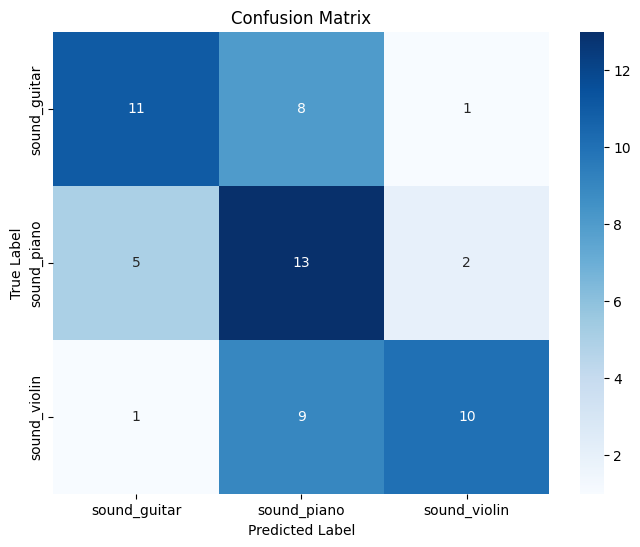


Evaluasi Eksperimen: AllFeatures
Akurasi  : 0.6000
Precision: 0.6648
Recall   : 0.6000
F1-Score : 0.5995

Classification Report:
              precision    recall  f1-score   support

sound_guitar       0.86      0.60      0.71        20
 sound_piano       0.47      0.80      0.59        20
sound_violin       0.67      0.40      0.50        20

    accuracy                           0.60        60
   macro avg       0.66      0.60      0.60        60
weighted avg       0.66      0.60      0.60        60



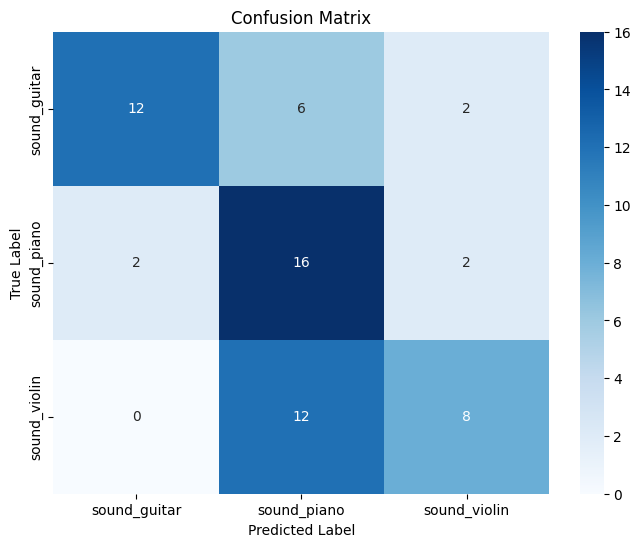

In [612]:
df_test = pd.read_csv("fitur_ekstraksi_test_gabungan.csv")
df_test['FileName'] = df_test['FileName'].str.replace('.wav', '', regex=False)

# Label
y_test = df_test['Class']

for exp_name, feature_cols in experiments.items():
    print(f"\nEvaluasi Eksperimen: {exp_name}")

    # Load scaler dan model
    scaler = joblib.load(f"scaler_{exp_name}.joblib")
    model  = joblib.load(f"model_{exp_name}.joblib")

    # Ambil fitur sesuai yang dipakai saat training
    feature_cols = scaler.feature_names_in_
    X_test_exp = df_test[feature_cols]

    # Transform test data
    X_test_scaled = scaler.transform(X_test_exp)

    # Prediksi
    y_pred_test = model.predict(X_test_scaled)
    
    # Hitung metrik
    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, average='macro')
    rec = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    
    print(f"Akurasi  : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    
    # Laporan Klasifikasi per kelas
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test, labels=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [600]:
def framing_windowing(signal, sample_rate=44100, frame_duration=0.025, hop_duration=0.01):
    frame_length = int(frame_duration * sample_rate)
    hop_length = int(hop_duration * sample_rate)

    # Jika sinyal terlalu pendek
    if len(signal) < frame_length:
        return np.array([])

    num_frames = 1 + int((len(signal) - frame_length) / hop_length)
    frames = np.zeros((num_frames, frame_length))
    window = hamming(frame_length, sym=False)
    
    for i in range(num_frames):
        start = i * hop_length
        frames[i] = signal[start:start + frame_length] * window
        
    return frames

INPUT_DIR = 'Test_submission_final'
FRAME_DURATION = 0.025  # 25ms
HOP_DURATION = 0.01     # 10ms
OUTPUT_DIR = 'Framed_Features_Test_NPZ'

os.makedirs(OUTPUT_DIR, exist_ok=True)

all_framed_data = {}

for file_name in os.listdir(INPUT_DIR):
    if file_name.endswith('.wav'):
        file_path = os.path.join(INPUT_DIR, file_name)
        try:
            y, sr = librosa.load(file_path, sr=44100)
            frames = framing_windowing(y, sample_rate=sr, frame_duration=FRAME_DURATION, hop_duration=HOP_DURATION)

            if frames.size > 0:
                all_framed_data[file_name] = frames
                npz_name = os.path.splitext(file_name)[0] + '.npz'
                np.savez_compressed(os.path.join(OUTPUT_DIR, npz_name),
                                    frames=frames, sr=sr)
                
                print(f"{file_name} → {frames.shape[0]} frame disimpan")
            else:
                print(f"{file_name} → sinyal terlalu pendek")

        except Exception as e:
            print(f"Gagal memproses {file_name}: {e}")

print("\nSemua hasil framing telah disimpan di folder:", OUTPUT_DIR)

acoustic-guitar-logo-13084.wav → 298 frame disimpan
guitar-chords-70663.wav → 298 frame disimpan
guitar-intro-110935.wav → 298 frame disimpan
guitar-solo-27194.wav → 298 frame disimpan
guitar-solo-5999.wav → 298 frame disimpan
guitar-solo-74247.wav → 298 frame disimpan
guitar-song-57789.wav → 298 frame disimpan
guitar-soundtrack-55233.wav → 298 frame disimpan
guitar-swellsolo-34241.wav → 298 frame disimpan
intro-music-black-box-simple-guitar-12701.wav → 298 frame disimpan
rock_1_100BPM.wav → 298 frame disimpan
rock_2_100BPM.wav → 298 frame disimpan
rock_3_100BPM.wav → 298 frame disimpan
rock_4_110BPM.wav → 298 frame disimpan
rock_5_100BPM.wav → 298 frame disimpan
rock_6_100BPM.wav → 298 frame disimpan
rock_7_100BPM.wav → 298 frame disimpan
rock_8_100BPM.wav → 298 frame disimpan
ROOM-room8-MUS-beethoven1.wav → 298 frame disimpan
ROOM-room8-MUS-beethoven2.wav → 298 frame disimpan
ROOM-room8-MUS-chords.wav → 298 frame disimpan
ROOM_room6_MUS_mozart_DEV_lg.wav → 298 frame disimpan
ROOM_roo

In [601]:
def process_npz_dataset(metadata_path, npz_dir, output_csv=None, sr=44100):
    metadata = pd.read_csv(metadata_path)
    results = []
    
    # Loop setiap baris di metadata
    for idx, row in metadata.iterrows():
        filename = row['FileName'] 
        
        base_name = os.path.splitext(filename)[0]
        npz_filename = base_name + '.npz'
        npz_path = os.path.join(npz_dir, npz_filename)
        
        try:
            # Load file NPZ
            frames, npz_metadata = load_npz_file(npz_path)
            
            if frames is None:
                print(f"Could not load frames from {npz_filename}")
                continue
            
            features_list = []
            
            # Ekstrak fitur untuk setiap frame
            for frame_idx, frame in enumerate(frames):
                # Pastikan frame adalah 1D array
                if frame.ndim > 1:
                    frame = frame.flatten()
                
                features = extract_features_per_frame(frame, sr)
                features_list.append(features)
            
            # Hitung statistik dari semua frame
            if features_list:
                df_features = pd.DataFrame(features_list)
                stats = {
                    'FileName': filename,
                    'num_frames': len(frames),

                    # ZCR
                    'zcr_mean': df_features['zcr'].mean(),
                    'zcr_std': df_features['zcr'].std(),

                    # RMS
                    'rms_mean': df_features['rms'].mean(),
                    'rms_std': df_features['rms'].std(),

                    # Spectral Centroid
                    'spectral_centroid_mean': df_features['spectral_centroid'].mean(),
                    'spectral_centroid_std': df_features['spectral_centroid'].std(),

                    # Spectral Spread
                    'spectral_spread_mean': df_features['spectral_spread'].mean(),
                    'spectral_spread_std': df_features['spectral_spread'].std(),

                    # Spectral Roll-Off
                    'spectral_rolloff_mean': df_features['spectral_rolloff'].mean(),
                    'spectral_rolloff_std': df_features['spectral_rolloff'].std(),
                }
                
                # Gabungkan dengan metadata asli
                for col in row.index:
                    if col != 'FileName':  # Hindari duplikat filename
                        stats[col] = row[col]
                
                results.append(stats)
            
        except Exception as e:
            print(f"Error processing {npz_filename}: {str(e)}")
            continue
    
    # Buat DataFrame hasil
    if results:
        result_df = pd.DataFrame(results)
        
        if output_csv:
            result_df.to_csv(output_csv, index=False)
            print(f"Semua hasil telah disimpan di folder: {output_csv}")
        
        return result_df
    else:
        print("No files were successfully processed!")
        return pd.DataFrame()

process_npz_dataset(
    metadata_path='Metadata_Test_Final.csv',
    npz_dir='Framed_Features_Test_NPZ',
    output_csv='fitur_ekstraksi_test.csv',
    sr=44100
)

Semua hasil telah disimpan di folder: fitur_ekstraksi_test.csv


,FileName,num_frames,zcr_mean,zcr_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_spread_mean,spectral_spread_std,spectral_rolloff_mean,spectral_rolloff_std,Class
0,acoustic-guitar-logo-13084.wav,298,0.022701,0.010897,0.063651,0.050208,1090.336414,469.981418,303.913761,258.939992,561.596974,209.601959,sound_guiatr
1,guitar-chords-70663.wav,298,0.021847,0.007807,0.035723,0.018142,1286.842386,227.942880,462.624127,154.233588,392.392721,167.620557,sound_guiatr
2,guitar-intro-110935.wav,298,0.012103,0.002285,0.111940,0.022005,408.974875,61.993873,114.634993,37.110608,337.468483,59.888176,sound_guiatr
3,guitar-solo-27194.wav,298,0.046864,0.013104,0.033156,0.006356,1488.754734,235.554953,783.288267,173.323290,1606.097516,544.699955,sound_guiatr
4,guitar-solo-5999.wav,298,0.048089,0.023375,0.129921,0.018722,1442.156296,351.359813,725.923843,233.960892,1542.444488,863.910345,sound_guiatr
5,guitar-solo-74247.wav,298,0.044017,0.013015,0.118878,0.033785,1564.892817,298.516968,610.830711,214.297226,1139.711507,696.620281,sound_guiatr
6,guitar-song-57789.wav,298,0.035613,0.015936,0.020926,0.006172,1159.805789,316.758146,646.647873,292.738504,1091.770302,902.376630,sound_guiatr
7,guitar-soundtrack-55233.wav,298,0.017516,0.003910,0.022412,0.012657,693.033593,266.824025,207.348331,105.284395,424.353524,38.386530,sound_guiatr
8,guitar-swellsolo-34241.wav,298,0.123957,0.018307,0.028431,0.006756,2813.188792,201.791081,1424.349388,170.505707,3806.289967,416.632903,sound_guiatr
9,intro-music-black-box-simple-guitar-12701.wav,298,0.031079,0.021289,0.031392,0.037188,3337.007074,1799.255458,1306.575676,879.794064,1052.960755,1242.493076,sound_guiatr


In [602]:
from scipy.fftpack import dct

metadata_train = pd.read_csv("Metadata_Test_Final.csv")  
npz_folder = "Framed_Features_Test_NPZ"

mfcc_list = []

for _, row in metadata_train.iterrows():
    filename = row['FileName'].replace('.wav', '.npz')
    label = row['Class']
    file_path = os.path.join(npz_folder, filename)

    try:
        # Set Parameter
        data = np.load(file_path)
        frames = data['frames']
        sr = int(data['sr'])
        n_fft = 2048
        n_mfcc = 13  

        if frames.shape[0] == 0:
            print(f"{filename} kosong → dilewati")
            continue
            
        if frames.shape[1] != n_fft:
            pad_width = max(0, n_fft - frames.shape[1])
            frames = np.pad(frames[:, :n_fft], ((0, 0), (0, pad_width)), mode='constant')

        # FFT Setiap Frame
        fft_frames = np.fft.rfft(frames, axis=1)
        power_spectrum = np.abs(fft_frames) ** 2
        log_power_spectrum = np.log10(power_spectrum + 1e-10)

        # Filterbank Mel
        mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mfcc)
        mel_spec = np.dot(power_spectrum, mel_filter.T)
        log_mel_spec = np.log(mel_spec + 1e-10)

        # DCT → MFCC
        mfcc = dct(log_mel_spec, type=2, axis=1, norm='ortho')[:, :n_mfcc]
        mfcc_mean = np.mean(mfcc, axis=0)
        mfcc_std = np.std(mfcc, axis=0)

        # Simpan list
        row_data = [filename] + mfcc_mean.tolist() + mfcc_std.tolist() + [label]
        mfcc_list.append(row_data)
    
    except Exception as e:
        print(f"Gagal memproses {filename}: {e}")

# Simpan ke file CSV
mfcc_columns = ['FileName'] + [f'MFCC_Mean_{i+1}' for i in range(n_mfcc)] + [f'MFCC_Std_{i+1}' for i in range(n_mfcc)] + ['Class']

df_train_mfcc = pd.DataFrame(mfcc_list, columns=mfcc_columns)
df_train_mfcc.to_csv("fitur_ekstraksi_test_mfcc.csv", index=False)

print(f"\nProses selesai MFCC disimpan di: {df_train_mfcc}")


Proses selesai MFCC disimpan di:                                              FileName  MFCC_Mean_1  \
0                      acoustic-guitar-logo-13084.npz   -22.214441   
1                             guitar-chords-70663.npz   -20.241556   
2                             guitar-intro-110935.npz   -22.683786   
3                               guitar-solo-27194.npz   -19.372157   
4                                guitar-solo-5999.npz   -10.006876   
5                               guitar-solo-74247.npz   -10.899561   
6                               guitar-song-57789.npz   -26.293223   
7                         guitar-soundtrack-55233.npz   -30.023523   
8                          guitar-swellsolo-34241.npz   -16.626147   
9       intro-music-black-box-simple-guitar-12701.npz   -42.686482   
10                                  rock_1_100BPM.npz   -40.962288   
11                                  rock_2_100BPM.npz   -32.383640   
12                                  rock_3_100BPM.npz   

In [603]:
df_fitur = pd.read_csv("fitur_ekstraksi_test.csv")
df_mfcc  = pd.read_csv("fitur_ekstraksi_test_mfcc.csv")

# Hapus ekstensi di kedua dataframe
df_fitur['FileName'] = df_fitur['FileName'].str.replace('.wav', '', regex=False)
df_mfcc['FileName']  = df_mfcc['FileName'].str.replace('.npz', '', regex=False)

# Betulkan typo label di kedua dataframe (kalau ternyata ada di dua-duanya)
label_mapping = {
    'sound_guiatr': 'sound_guitar',
    ' sound_piano': 'sound_piano'  # kalau mau aman sekalian rapihin spasi
}

df_fitur['Class'] = df_fitur['Class'].replace(label_mapping)
df_mfcc['Class']  = df_mfcc['Class'].replace(label_mapping)

# Gabungkan berdasarkan FileName dan Class
df_gabung = pd.merge(df_fitur, df_mfcc, on=['FileName', 'Class'])

# Cek hasil kolom gabungan
print(df_gabung.columns.tolist())

# Urutkan kolom
cols = (['FileName'] + 
        [col for col in df_gabung.columns if col not in ['FileName', 'Class']] + 
        ['Class'])
df_gabung = df_gabung[cols]

# Simpan hasil gabungan
df_gabung.to_csv("fitur_ekstraksi_test_gabungan.csv", index=False)
print("Berhasil digabung")

['FileName', 'num_frames', 'zcr_mean', 'zcr_std', 'rms_mean', 'rms_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_spread_mean', 'spectral_spread_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'Class', 'MFCC_Mean_1', 'MFCC_Mean_2', 'MFCC_Mean_3', 'MFCC_Mean_4', 'MFCC_Mean_5', 'MFCC_Mean_6', 'MFCC_Mean_7', 'MFCC_Mean_8', 'MFCC_Mean_9', 'MFCC_Mean_10', 'MFCC_Mean_11', 'MFCC_Mean_12', 'MFCC_Mean_13', 'MFCC_Std_1', 'MFCC_Std_2', 'MFCC_Std_3', 'MFCC_Std_4', 'MFCC_Std_5', 'MFCC_Std_6', 'MFCC_Std_7', 'MFCC_Std_8', 'MFCC_Std_9', 'MFCC_Std_10', 'MFCC_Std_11', 'MFCC_Std_12', 'MFCC_Std_13']
Berhasil digabung


In [599]:
AUDIO_DIR = 'Test_submission_final'
EXPECTED_DURATION = 3.0  
SILENCE_THRESHOLD = 0.003
instrument = ''  

# Load metadata
df = pd.read_csv('Metadata_Test_Final.csv') 

# Filter hanya instrumen yang ingin diperiksa
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Untuk mencatat anomali
anomali_files = []

# Loop per file
for idx, row in filtered.iterrows():
    file_name = row['FileName']
    full_path = os.path.join(AUDIO_DIR, file_name)

    try:
        # Load file audio
        y, sr = librosa.load(full_path, sr=None)

        # Cek durasi
        duration = librosa.get_duration(y=y, sr=sr)
        if duration < EXPECTED_DURATION:
            anomali_files.append((file_name, "Durasi kurang"))

        # Cek apakah audio terlalu sunyi
        rms = np.sqrt(np.mean(y ** 2))
        if rms < SILENCE_THRESHOLD:
            anomali_files.append((file_name, "Terlalu sunyi / tidak ada suara"))

        # Cek apakah spektrum flat (noise atau file kosong)
        spec = np.abs(librosa.stft(y))
        spectral_flatness = librosa.feature.spectral_flatness(S=spec)
        if np.mean(spectral_flatness) > 1.0:  # flatness tinggi = noise / tidak ada pitch
            anomali_files.append((file_name, "Spektrum terlalu flat (mungkin noise)"))

    except Exception as e:
        anomali_files.append((file_name, f"Error saat dibaca: {str(e)}"))

# Tampilkan hasil
if anomali_files:
    print("Ditemukan file dengan potensi anomali:")
    for file, issue in anomali_files:
        print(f"- {file}: {issue}")
else:
    print("Semua file audio terlihat normal.")

Semua file audio terlihat normal.
